In [82]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm
import h5py

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/lane/.local/lib/python3.4/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Changes from previous versions:
- Constrain spacing by photoreceptor spacing
- Constrain width by visual field of salamander retina  
- Constrain output power instead of output variance

In [57]:
microns_per_degree = 50.0 # depends on species; this is for salamander
photoreceptor_width = 10.0/microns_per_degree # salamander photoreceptors have width of 10-20 microns
retina_width = 4000.0/microns_per_degree # salamander retina is about 4 mm
frequency_spacing = 1./retina_width # this is the lowest non-DC frequency we can estimate
highest_frequency = 0.5/photoreceptor_width # this is the highest frequency we can estimate (Nyquist freq.)

N = retina_width//photoreceptor_width
freqs = np.linspace(0, highest_frequency, N//2 + 1)
space = np.concatenate([np.linspace(-0.5*retina_width, 0, N//2 + 1)[:-1], np.linspace(0, 0.5*retina_width, N//2 + 1)])

### Load receptive fields

In [60]:
# These are loaded as (space, receptive) field tuples
cells = {}
cells['ganglion'] = load_new_ganglion_cells(space_mode='peak')
cells['bipolar'] = load_bipolar_cells(space_mode='peak')
cells['amacrine'] = load_amacrine_cells(space_mode='peak')
cells['horizontal'] = load_horizontal_cells(space_mode='peak')

In [61]:
receptive_fields = collections.defaultdict(list)
for c in cells.keys():
    for s, rf in cells[c]:
        this_cell_interp = interp1d(s, rf, kind='slinear', bounds_error=False, fill_value=[0])
        receptive_fields[c].append(this_cell_interp(space))
        
average_ganglion_rf = np.mean(receptive_fields['ganglion'], axis=0)

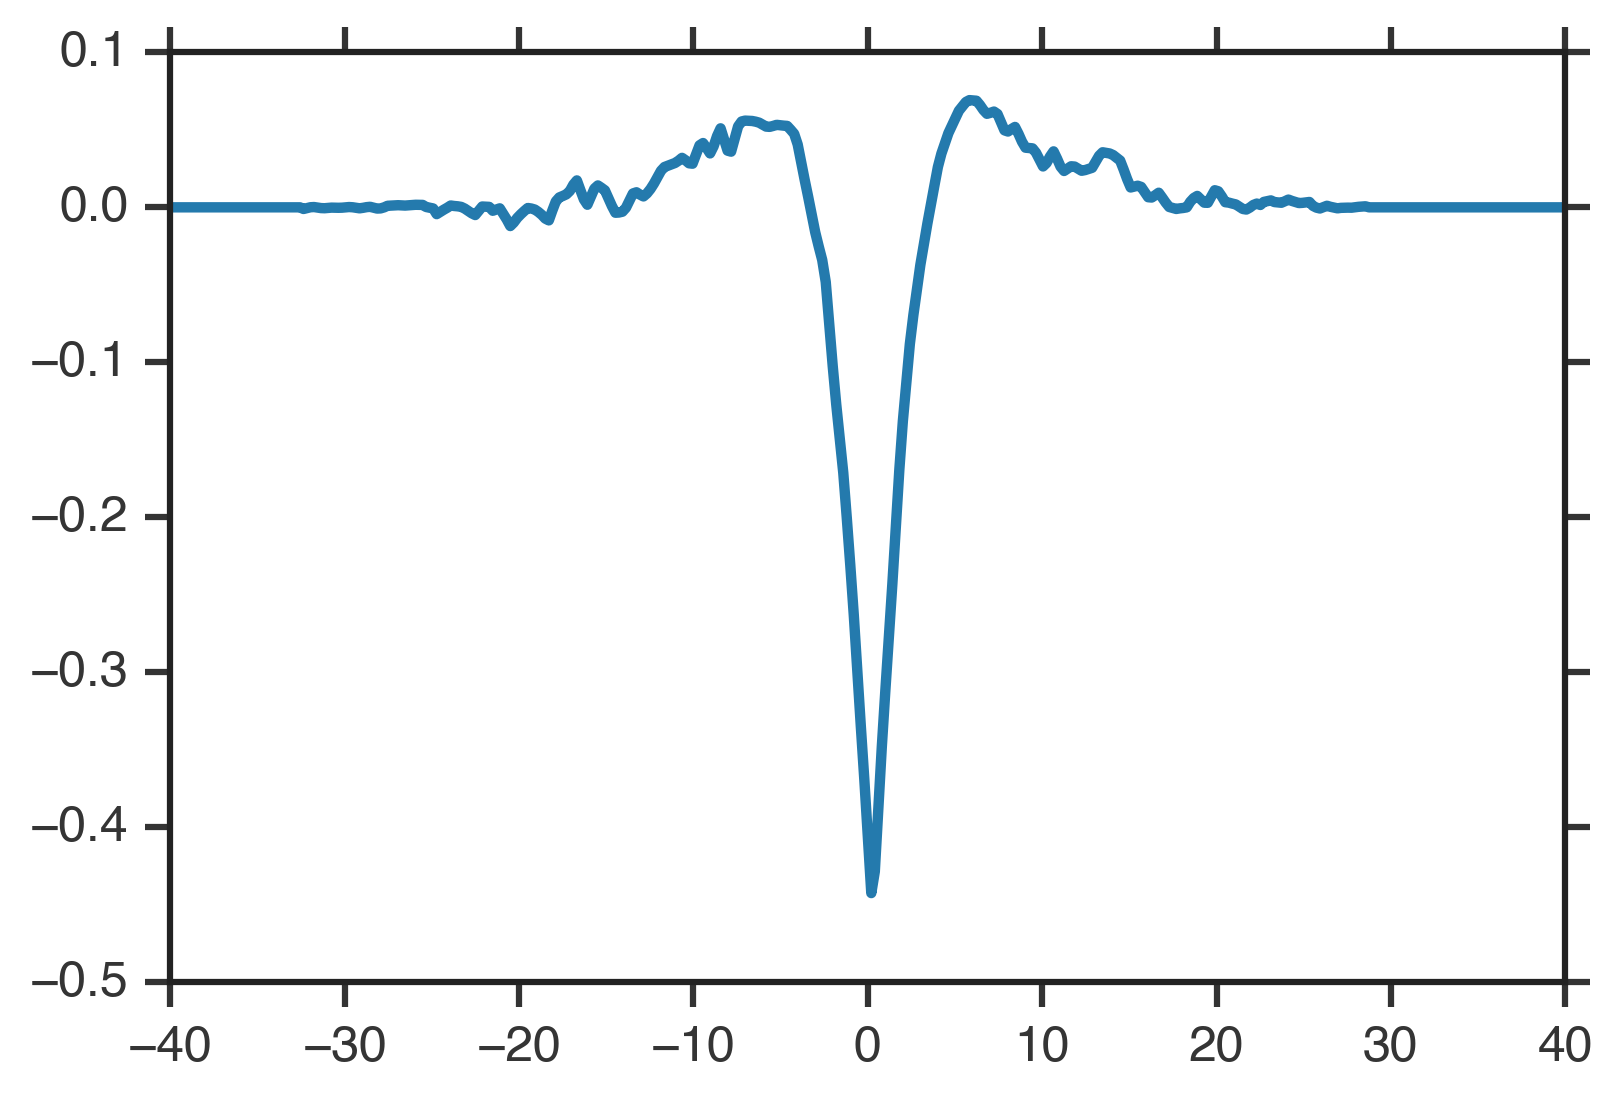

In [120]:
plt.plot(space, average_ganglion_rf)

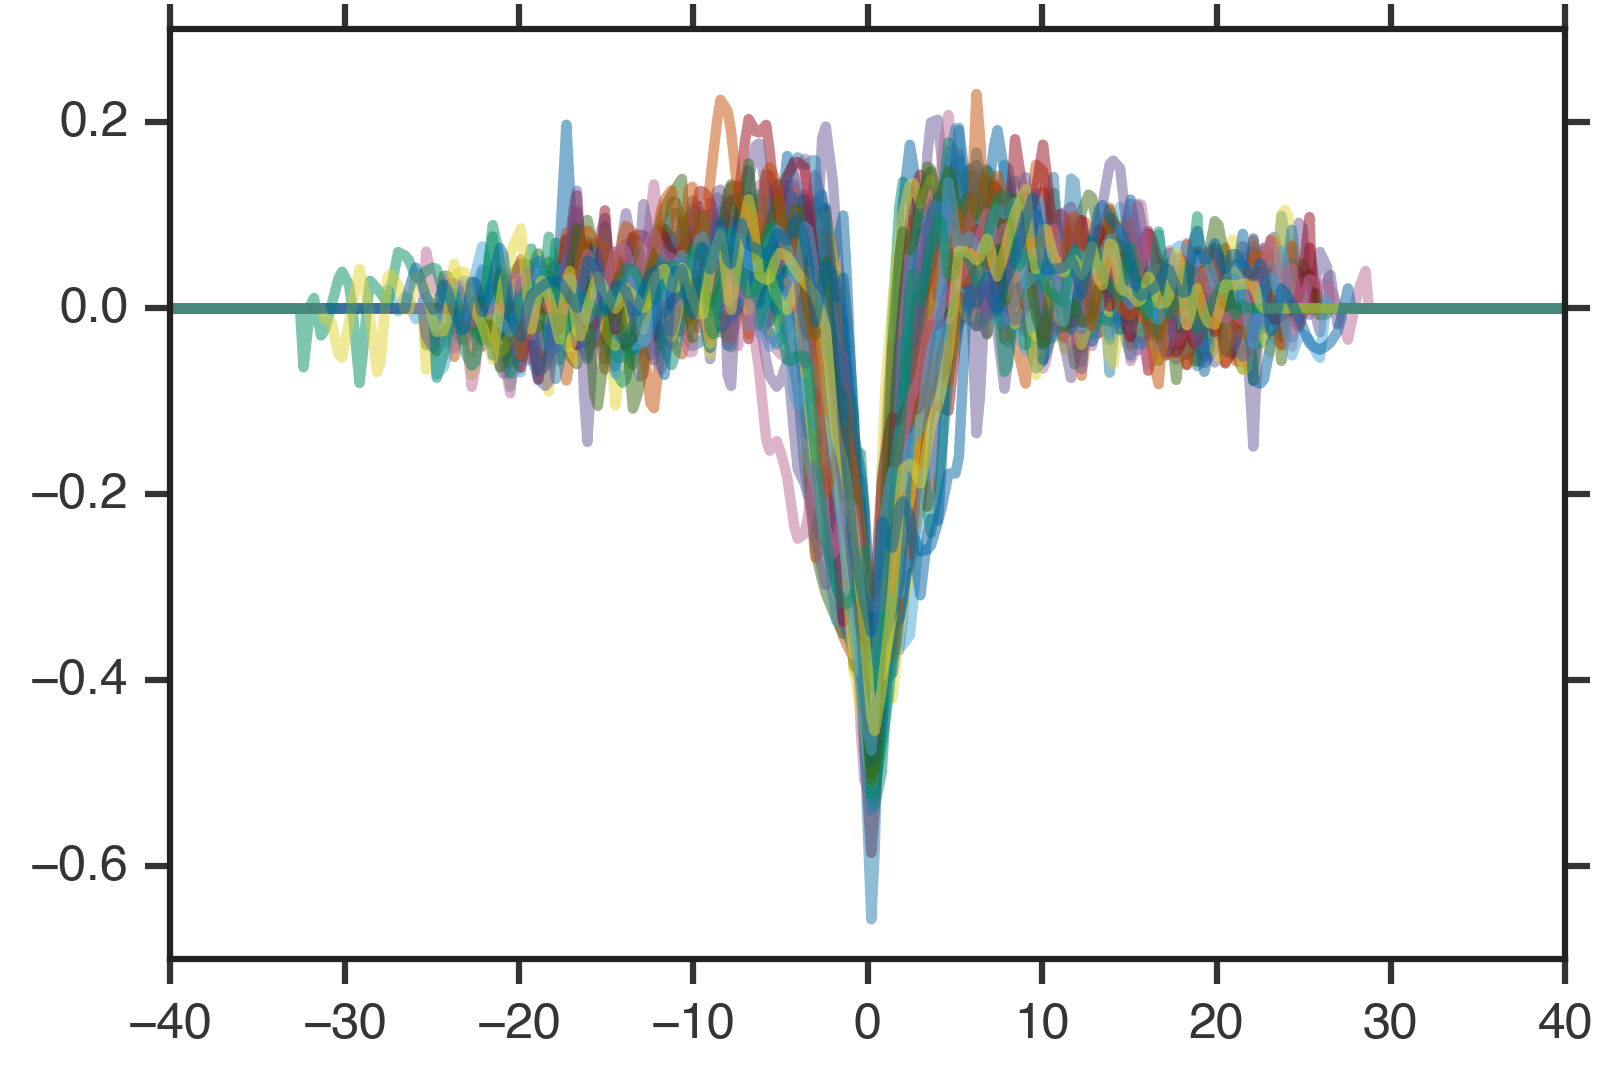

In [122]:
for rf in receptive_fields['ganglion']:
    plt.plot(space, rf, alpha=0.5)

### Compute projective fields

In [62]:
horz_pfs_full = get_horizontal_projective_field(conv_mode='full')
horz_pfs_same = get_horizontal_projective_field(conv_mode='same')
ama_pfs_full = get_amacrine_projective_field(conv_mode='full')
ama_pfs_same = get_amacrine_projective_field(conv_mode='same')

space_h_full, horz_pf_full, horz_sem_full = get_mean(horz_pfs_full)
space_h_same, horz_pf_same, horz_sem_same = get_mean(horz_pfs_same)
space_a_full, ama_pf_full, ama_sem_full = get_mean(ama_pfs_full)
space_a_same, ama_pf_same, ama_sem_same = get_mean(ama_pfs_same)

In [63]:
horz_pf_interp = interp1d(space_h_full, horz_pf_full, kind='slinear', bounds_error=False, fill_value=[0])
ama_pf_interp = interp1d(space_a_full, ama_pf_full, kind='slinear', bounds_error=False, fill_value=[0])

horz_pf = horz_pf_interp(space)
ama_pf = ama_pf_interp(space)

### Signal

In [64]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = expanduser('~/data/images/Tkacik/cd01A')
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)
signal_amps, signal_freqs, signal_sem = averageAmplitudeSpectrum2d(patches, spacing=spacing)

Only 70 files in directory.


In [65]:
def func(x, a, b):
    return a/(x**b) # adding a constant tends to make moreSpectra have negative numbers

popt_signal, pcov  = curve_fit(func, signal_freqs[1:], signal_amps[1:])
print(popt_signal)
signal = func(freqs, *popt_signal)
signal[0] = np.sqrt(np.sum(signal[1:]))

[ 0.0056951   1.01550079]


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


### Noise  
Note that the amplitude of the average_ganglion_fft will change the SNR. As the amplitude $\rightarrow \infty$, we get $$\rm{SNR} \rightarrow \frac{\sum (\rm{filter}_{1:f} \times \rm{signal}_{1:f})^2}{\sum (\rm{filter}_{1:f} \times N_{\rm{in}})^2}$$.  

Since the scale of the ganglion fft is arbitrary, we can look at the SNR in this limit.

In [66]:
input_noise = 0.098762200628786892
output_noise = 0.35
target_power = 54.131410989171826

1.80930888954


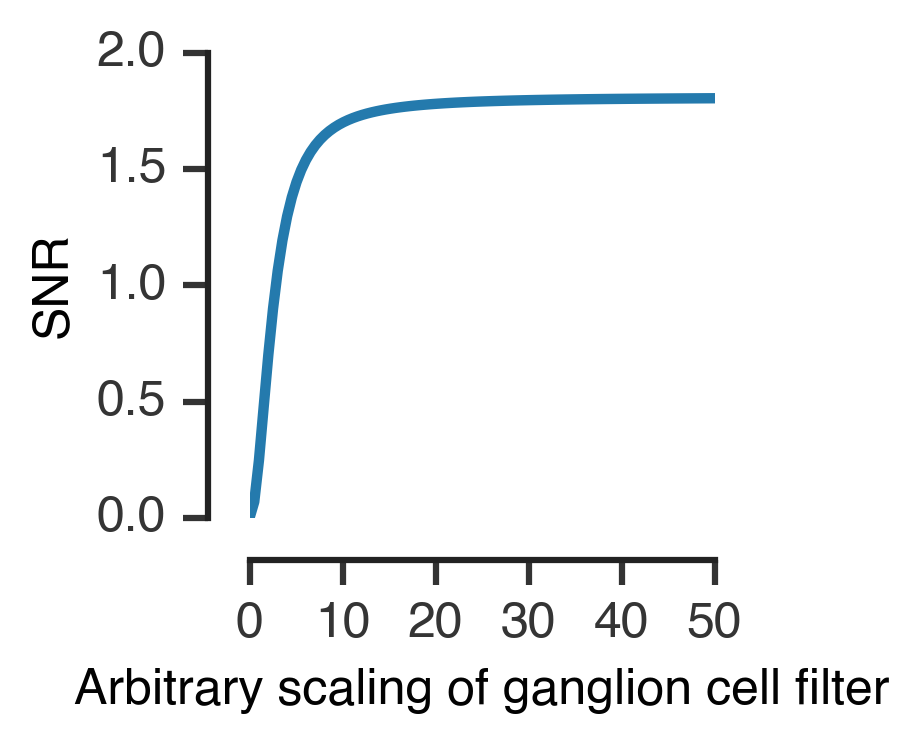

In [67]:
fig = plt.gcf()
fig.set_size_inches((2,2))
average_ganglion_fft = abs(np.fft.rfft(average_ganglion_rf))
print(get_snr(input_noise, output_noise, signal, 1000*average_ganglion_fft, mode='variance'))
snrs = [get_snr(input_noise, output_noise, signal, c*average_ganglion_fft) for c in np.linspace(0,50,100)]
plt.plot(np.linspace(0,50,100), snrs)
adjust_spines(plt.gca())
plt.xlabel('Arbitrary scaling of ganglion cell filter')
plt.ylabel('SNR')

In [68]:
# SNR = 0.269 is total SNR from ganglion recordings of 112 repeats to 30 seconds natural scenes
def find_filt_const(filt_const):
    this_snr = get_snr(input_noise, output_noise, signal, filt_const*average_ganglion_fft, mode='variance')
    return (this_snr - 0.26912469)**2

filt_const_opt = scipy.optimize.minimize_scalar(find_filt_const)

print(get_snr(input_noise, output_noise, signal, filt_const_opt.x*average_ganglion_fft, mode='variance'))

0.269124687467


### Ideal filter

In [69]:
ideal_filter = unique_soln(signal**2, input_noise, output_noise)

The relative error from this choice of Lagrangian multiplier is 4.17104821707e-07.


### Model of Horizontal Projective Field + Amacrine Projective Field + Center

In [70]:
horz_pf /= np.sum(horz_pf)
ama_pf /= np.sum(ama_pf)

Load David's 1721 ganglion cells

In [71]:
data_path = expanduser('~/data/kastner/receptive_fields/')
spatialDelta = 0.05 # mm
micronsPerDeg = 50.
ganglion_rfs = {
    'fast_on': np.loadtxt(data_path + 'linesRF1.txt').reshape((126, 101, -1)),
    'fast_off_adapting': np.loadtxt(data_path + 'linesRF19.txt').reshape((-1, 101, 96)),
    'fast_off_sensitizing': np.loadtxt(data_path + 'linesRF8.txt').reshape((-1, 101, 96)),
    'medium_off_adapting': np.loadtxt(data_path + 'linesRF29.txt').reshape((-1, 101, 96)),
    'slow_off': np.loadtxt(data_path + 'linesRF17.txt').reshape((-1, 101, 96)),
}

In [72]:
for celltype in ganglion_rfs.keys():
    for rf in ganglion_rfs[celltype]:
        # since receptive fields are noisy, use PCA
        pca = PCA(n_components=2)
        pca.fit(rf)
        g_pca = pca.components_[0]

        sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
        this_space = get_space(g_pca, spatialDelta, micronsPerDeg, kind='peak')
        
        rf_interp = interp1d(this_space, sign_of_pc*g_pca, kind='slinear', bounds_error=False, fill_value=[0])

        receptive_fields[celltype].append(rf_interp(space))

Get center widths for each celltype

In [73]:
diff_of_gauss_mu0 = partial(difference_of_gaussians, mu=0)

In [74]:
def center_and_surround(space, center_width, surround_width, center_strength, surround_strength):
    return diff_of_gauss_mu0(space, abs(center_width), abs(surround_width),
                            -abs(center_strength), abs(surround_strength))

In [75]:
center_widths = collections.defaultdict(list)
surround_widths = collections.defaultdict(list)
center_strengths = collections.defaultdict(list)
surround_strengths = collections.defaultdict(list)
fit_failures = collections.defaultdict(list)

for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']:
        
        for idg, g in tqdm(enumerate(receptive_fields[celltype])):
            try:
                popt_this, pcov = curve_fit(center_and_surround, space, g, p0=[1.5, 3.5, -10, 30])
                center_id = np.argmin(abs(popt_this[:2]))
                surround_id = 1 ^ center_id
                center_widths[celltype].append(abs(popt_this[center_id]))
                surround_widths[celltype].append(abs(popt_this[surround_id]))
                center_strengths[celltype].append(popt_this[center_id+2])
                surround_strengths[celltype].append(popt_this[surround_id+2])
#                 plt.plot(space, diff_of_gauss_mu0(space, *popt_this), color=np.random.rand(3), alpha=0.6)
            except:
                fit_failures[celltype].append(idg)
            
                # just set params to median across cells
                # this way the params are still aligned with the receptive field id
                center_widths[celltype].append(np.median(center_widths[celltype]))
                surround_widths[celltype].append(np.median(surround_widths[celltype]))
                center_strengths[celltype].append(np.median(center_strengths[celltype]))
                surround_strengths[celltype].append(np.median(surround_strengths[celltype]))
                
#                 print("Couldn't fit cell %d" %idg)

321it [00:48,  9.68it/s]
772it [01:27, 12.29it/s]
253it [01:45,  5.76it/s]
60it [00:13,  4.43it/s]
126it [00:29,  5.75it/s]
249it [00:55,  6.03it/s]


In [76]:
for f in fit_failures.keys():
    print("couldn't fit %d in %s" %(len(fit_failures[f]), f))

couldn't fit 6 in medium_off_adapting
couldn't fit 31 in slow_off
couldn't fit 4 in fast_off_adapting
couldn't fit 4 in ganglion
couldn't fit 9 in fast_off_sensitizing
couldn't fit 5 in fast_on


Plot the average profile across celltypes

In [77]:
median_center_widths = {}
for celltype in center_widths.keys():
    cws = np.array(center_widths[celltype])
    sws = np.array(surround_widths[celltype])
    css = np.array(center_strengths[celltype])
    sss = np.array(surround_strengths[celltype])
#     mean_center_widths[celltype] = np.mean(cws[cws < 500])
#     mean_surround_width = np.mean(sws[sws < 500])
#     mean_center_strength = np.mean(css[abs(css) < 500])
#     mean_surround_strength = np.mean(sss[abs(sss) < 500])
    
    median_center_widths[celltype] = np.median(abs(cws))
    median_surround_width = np.median(abs(sws))
    median_center_strength = np.median(-abs(css))
    median_surround_strength = np.median(abs(sss))
#     plt.plot(space, diff_of_gauss_mu0(space, median_center_widths[celltype], median_surround_width,
#                                      median_center_strength, median_surround_strength), label=celltype)
# plt.legend(frameon=False, fontsize=9, loc='lower left')
# adjust_spines(plt.gca())

In [78]:
median_center_widths

{'fast_off_adapting': 1.6921005125265909,
 'fast_off_sensitizing': 2.0658102863813603,
 'fast_on': 1.9647399365227634,
 'ganglion': 1.5412227043448907,
 'medium_off_adapting': 1.5794333062701262,
 'slow_off': 1.5642116410053606}

Bar charts to visualize diversity

# Fig 1 new figs

In [83]:
data_dir = os.path.expanduser('~/data/kastner/')
h_file = 'horizontals.h5'
a_file = 'amacrines.h5'

interneuron_rfs = collections.defaultdict(list)
with h5py.File(data_dir + h_file, 'r') as f:
    keys = [str(k)[3:-2] for k in list(f['expts'])]
    for ide,expt in tqdm(enumerate(keys)):
        rf = np.array(f['lines/rfs/%s' %expt])
        pca = PCA(n_components=2)
        pca.fit(rf)
        g_pca = pca.components_[0]

        sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
        interneuron_rfs['horizontal'].append(sign_of_pc * g_pca)

with h5py.File(data_dir + a_file, 'r') as f:
    keys = [str(k)[3:-2] for k in list(f['expts'])]
    for ide,expt in tqdm(enumerate(keys)):
        rf = np.array(f['lines/rfs/%s' %expt])
        pca = PCA(n_components=2)
        pca.fit(rf)
        g_pca = pca.components_[0]

        sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
        interneuron_rfs['amacrine'].append(sign_of_pc * g_pca)
        
space_constant = {
    'horizontal': 118./microns_per_degree,
    'amacrine': 78./microns_per_degree
    }
conv_mode = 'full'
# spatial delta in mm * 1000) / microns_per_degree # microns * degrees/microns = degrees
interneuron_spacing = (2.2/100.) # in mm

interneuron_rfs_1d = collections.defaultdict(list)
for interneuron_type in interneuron_rfs.keys():
    for rf in interneuron_rfs[interneuron_type]:
        this_space = get_space(rf, interneuron_spacing, microns_per_degree, in_degrees=True, kind='peak')
        proj_range = [np.exp(-abs(t)/space_constant[interneuron_type]) for t in np.linspace(np.min(this_space),
                                                                                    np.max(this_space),len(this_space))]
        proj_field = np.convolve(proj_range, rf, mode=conv_mode)
        proj_field *= np.mean(rf) / np.mean(proj_field)
        
        proj_space = get_space(proj_field, np.diff(this_space[:2]), microns_per_degree, in_degrees=False)
        component_interp = interp1d(proj_space, proj_field, kind='slinear', bounds_error=False, fill_value=[0])
        interneuron_rfs_1d[interneuron_type].append(component_interp(space))
        
interneuron_fits = collections.defaultdict(list)
for interneuron_type in interneuron_rfs_1d.keys():
    for component in interneuron_rfs_1d[interneuron_type]:
        popt, pcov = curve_fit(gaussian, space, -component, p0=[2.5, 0.0, 2.1])
        interneuron_fits[interneuron_type].append(abs(popt[0]))

9it [00:00, 423.52it/s]
27it [00:00, 523.04it/s]


(2.1, 10.1)

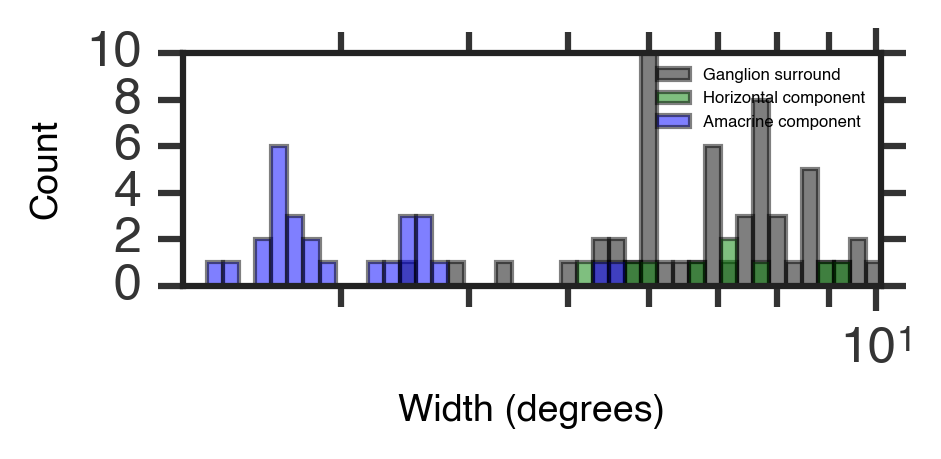

In [84]:
fig = plt.gcf()
fig.set_size_inches((3,1))

# bins = np.linspace(np.min([np.min(interneuron_fits['horizontal']),
#                           np.min(interneuron_fits['amacrine']),
#                           np.min(surround_widths['ganglion'])]),
#                   np.max([np.max(interneuron_fits['horizontal']),
#                           np.max(interneuron_fits['amacrine']),
#                           np.max(surround_widths['ganglion'])]), 20)
bins = np.logspace(0.33, 1.1)

count_ganglion, bins = np.histogram(surround_widths['ganglion'], bins=bins)
count_horz, bins = np.histogram(interneuron_fits['horizontal'], bins=bins)
count_ama, bins = np.histogram(interneuron_fits['amacrine'], bins=bins)
bin_width = np.mean(np.diff(bins))

plt.bar(bins[:-1], count_ganglion, width=np.diff(bins), color='k', alpha=0.5, label='Ganglion surround')
plt.bar(bins[:-1], count_horz, width=np.diff(bins), color='g', alpha=0.5, label='Horizontal component')
plt.bar(bins[:-1], count_ama, width=np.diff(bins), color='b', alpha=0.5, label='Amacrine component')
plt.legend(loc='upper right', frameon=False, fontsize=4)
plt.xlabel('Width (degrees)', fontsize=9)
plt.ylabel('Count', fontsize=9)
plt.xscale('log')
plt.xlim([2.1, 10.1])

## New figures for Fig 2 E,F

#### Mean horz, amacrine cells

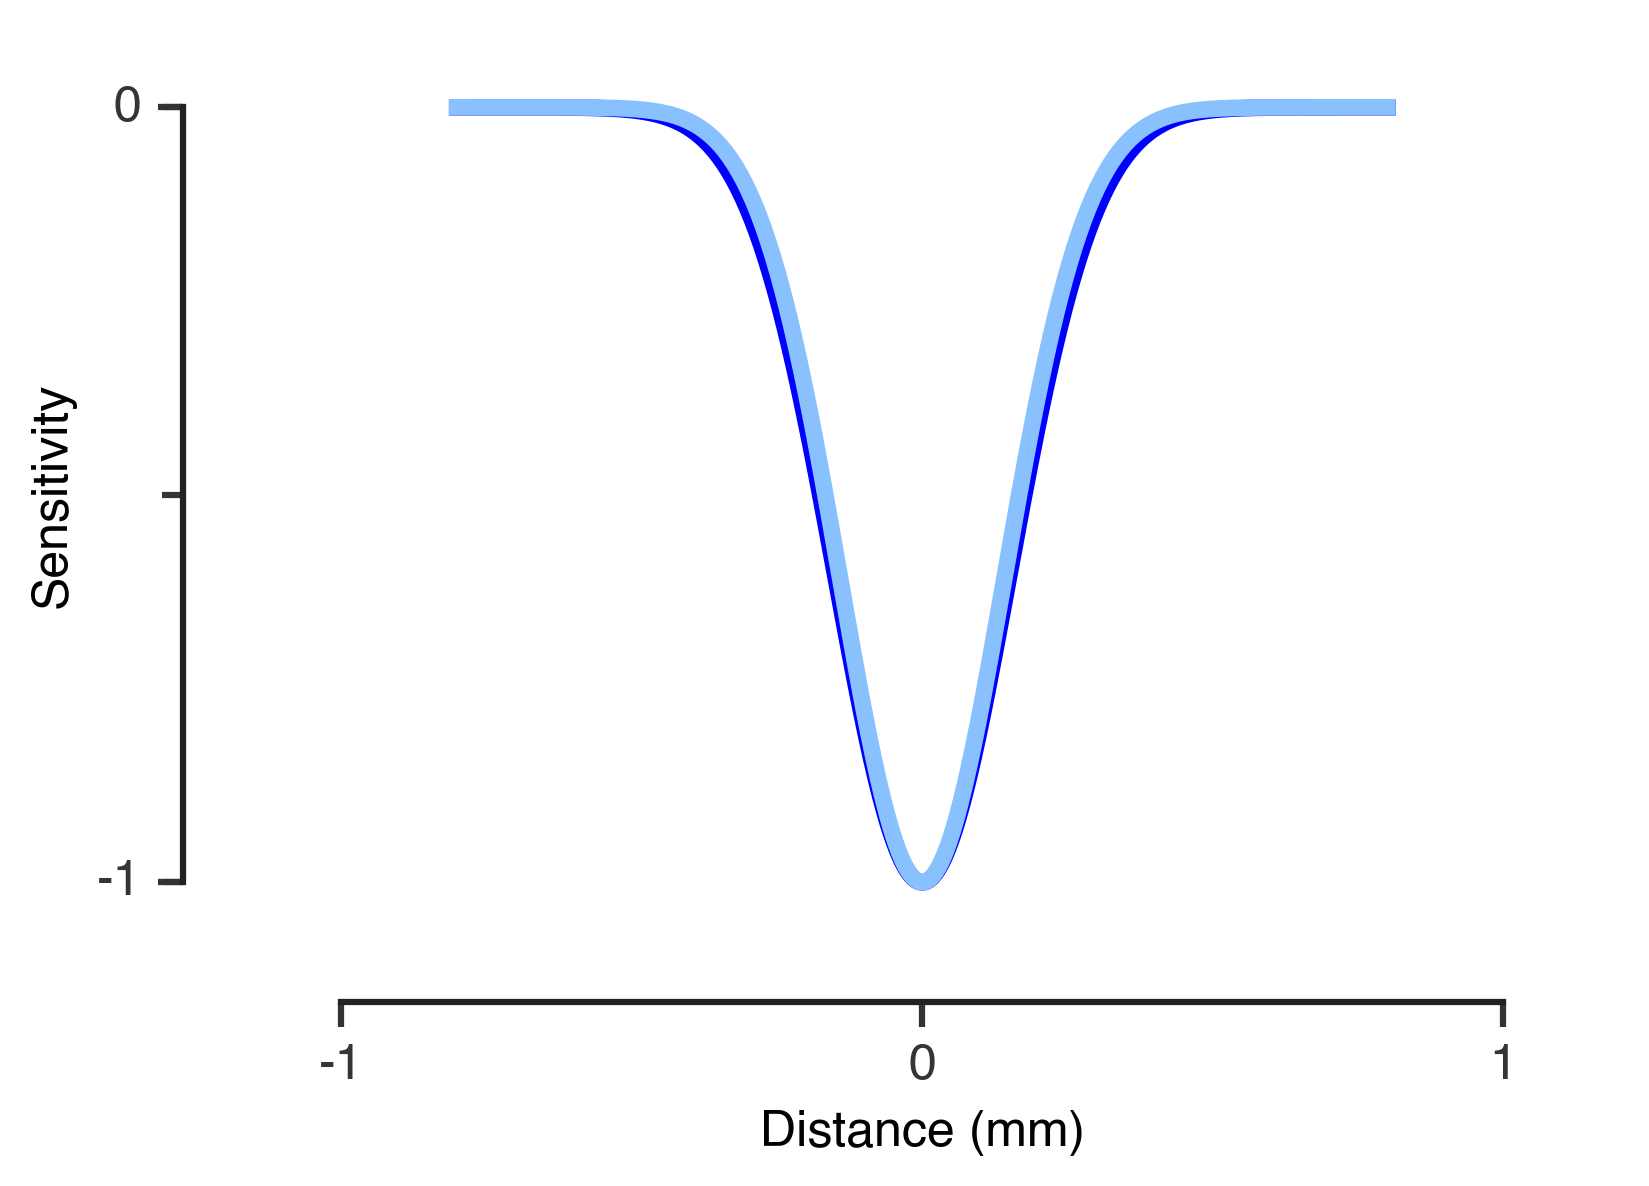

In [85]:
ganglion_surround = gaussian(space, np.mean(surround_widths['ganglion']), 0, 1)
horz_surround = gaussian(space, np.mean(interneuron_fits['horizontal']), 0, 1)
ama_surround = gaussian(space, np.mean(interneuron_fits['amacrine']), 0, 1)

plt.plot(space/50, -ganglion_surround/np.max(abs(ganglion_surround)), color='#0000FE', linewidth=4)
plt.plot(space/50, -horz_surround/np.max(abs(horz_surround)), color='#89C0FE', linewidth=4)
# plt.plot(space, ama_surround/np.max(abs(ama_surround)), color='#0000FE', linewidth=4)
plt.xlabel('Distance (mm)')
plt.ylabel('Sensitivity')

majorLocator = MultipleLocator(1.0)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)



plt.ylim(-1.1,0.1)
plt.xlim(-1.2,1.2)
adjust_spines(plt.gca())

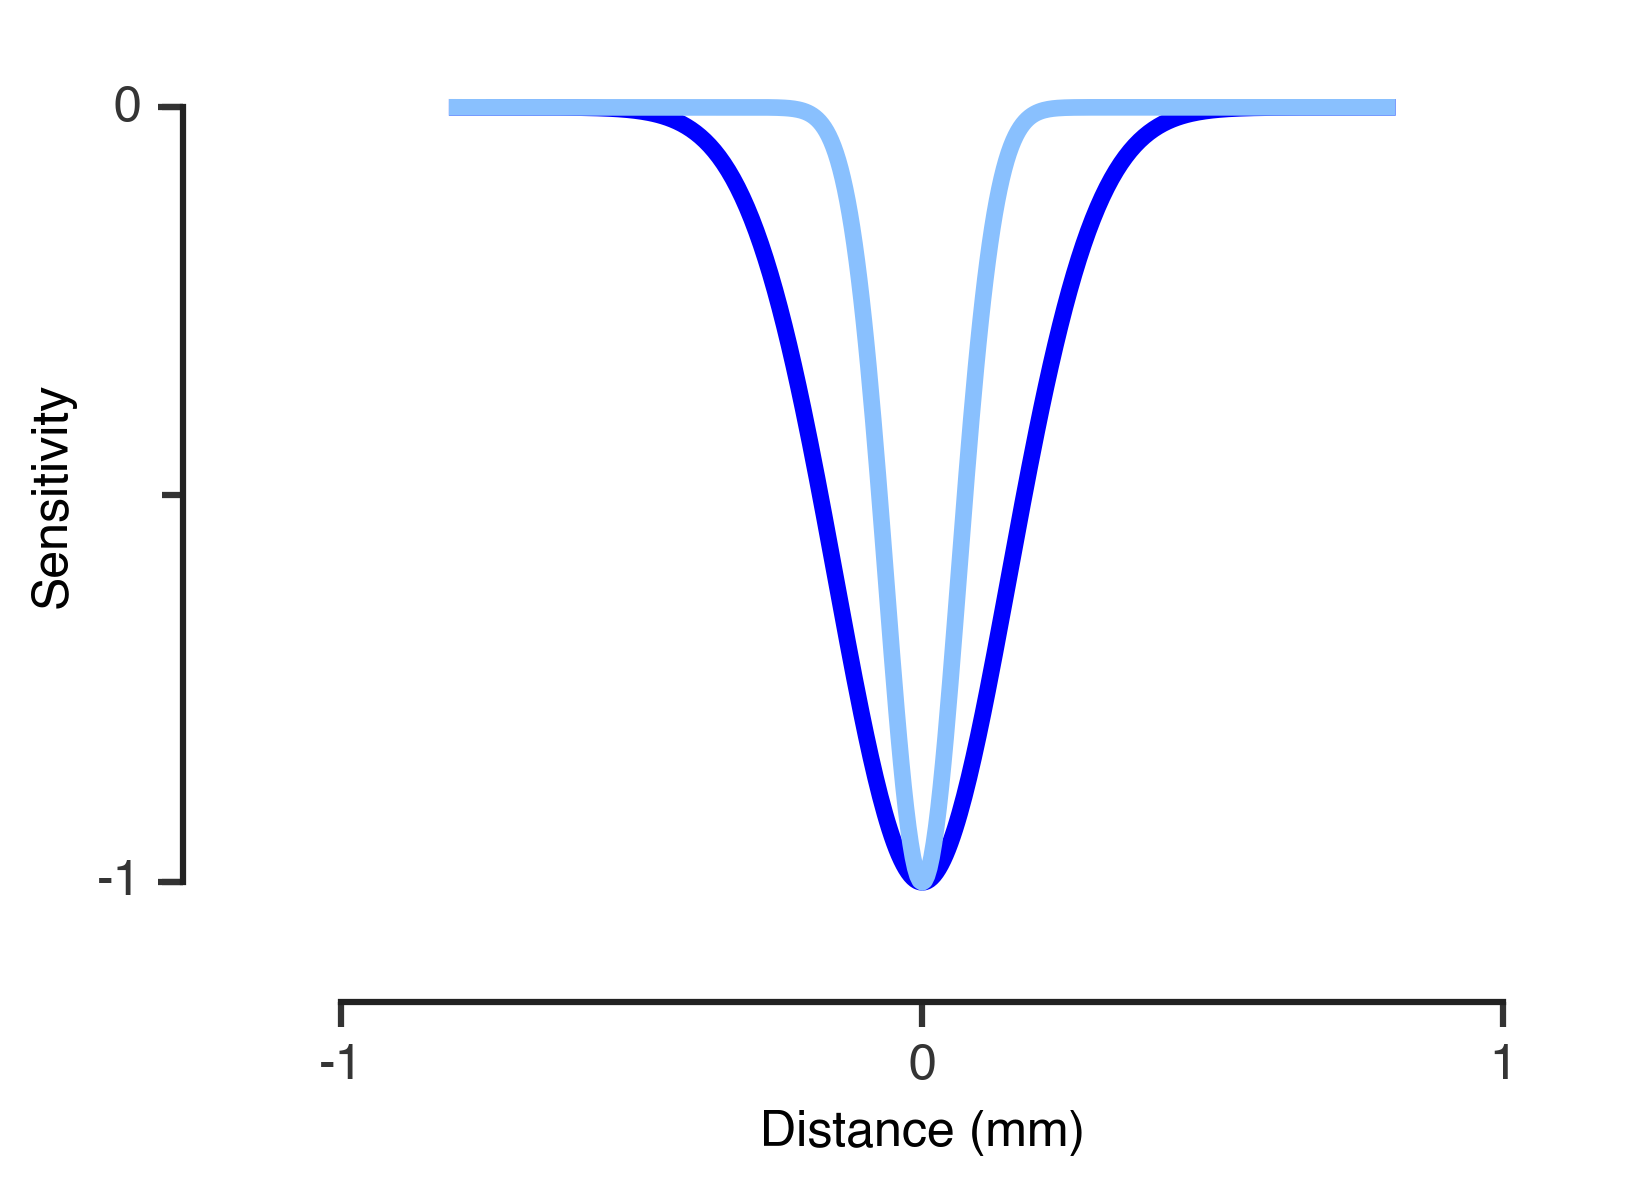

In [86]:
ganglion_surround = gaussian(space, np.mean(surround_widths['ganglion']), 0, 1)
horz_surround = gaussian(space, np.mean(interneuron_fits['horizontal']), 0, 1)
ama_surround = gaussian(space, np.mean(interneuron_fits['amacrine']), 0, 1)

plt.plot(space/50, -ganglion_surround/np.max(abs(ganglion_surround)), color='#0000FE', linewidth=4)
# plt.plot(space/50, -horz_surround/np.max(abs(horz_surround)), color='#89C0FE', linewidth=4)
plt.plot(space/50, -ama_surround/np.max(abs(ama_surround)), color='#89C0FE', linewidth=4)
plt.xlabel('Distance (mm)')
plt.ylabel('Sensitivity')

majorLocator = MultipleLocator(1.0)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)



plt.ylim(-1.1,0.1)
plt.xlim(-1.2,1.2)
adjust_spines(plt.gca())

#### Max and min

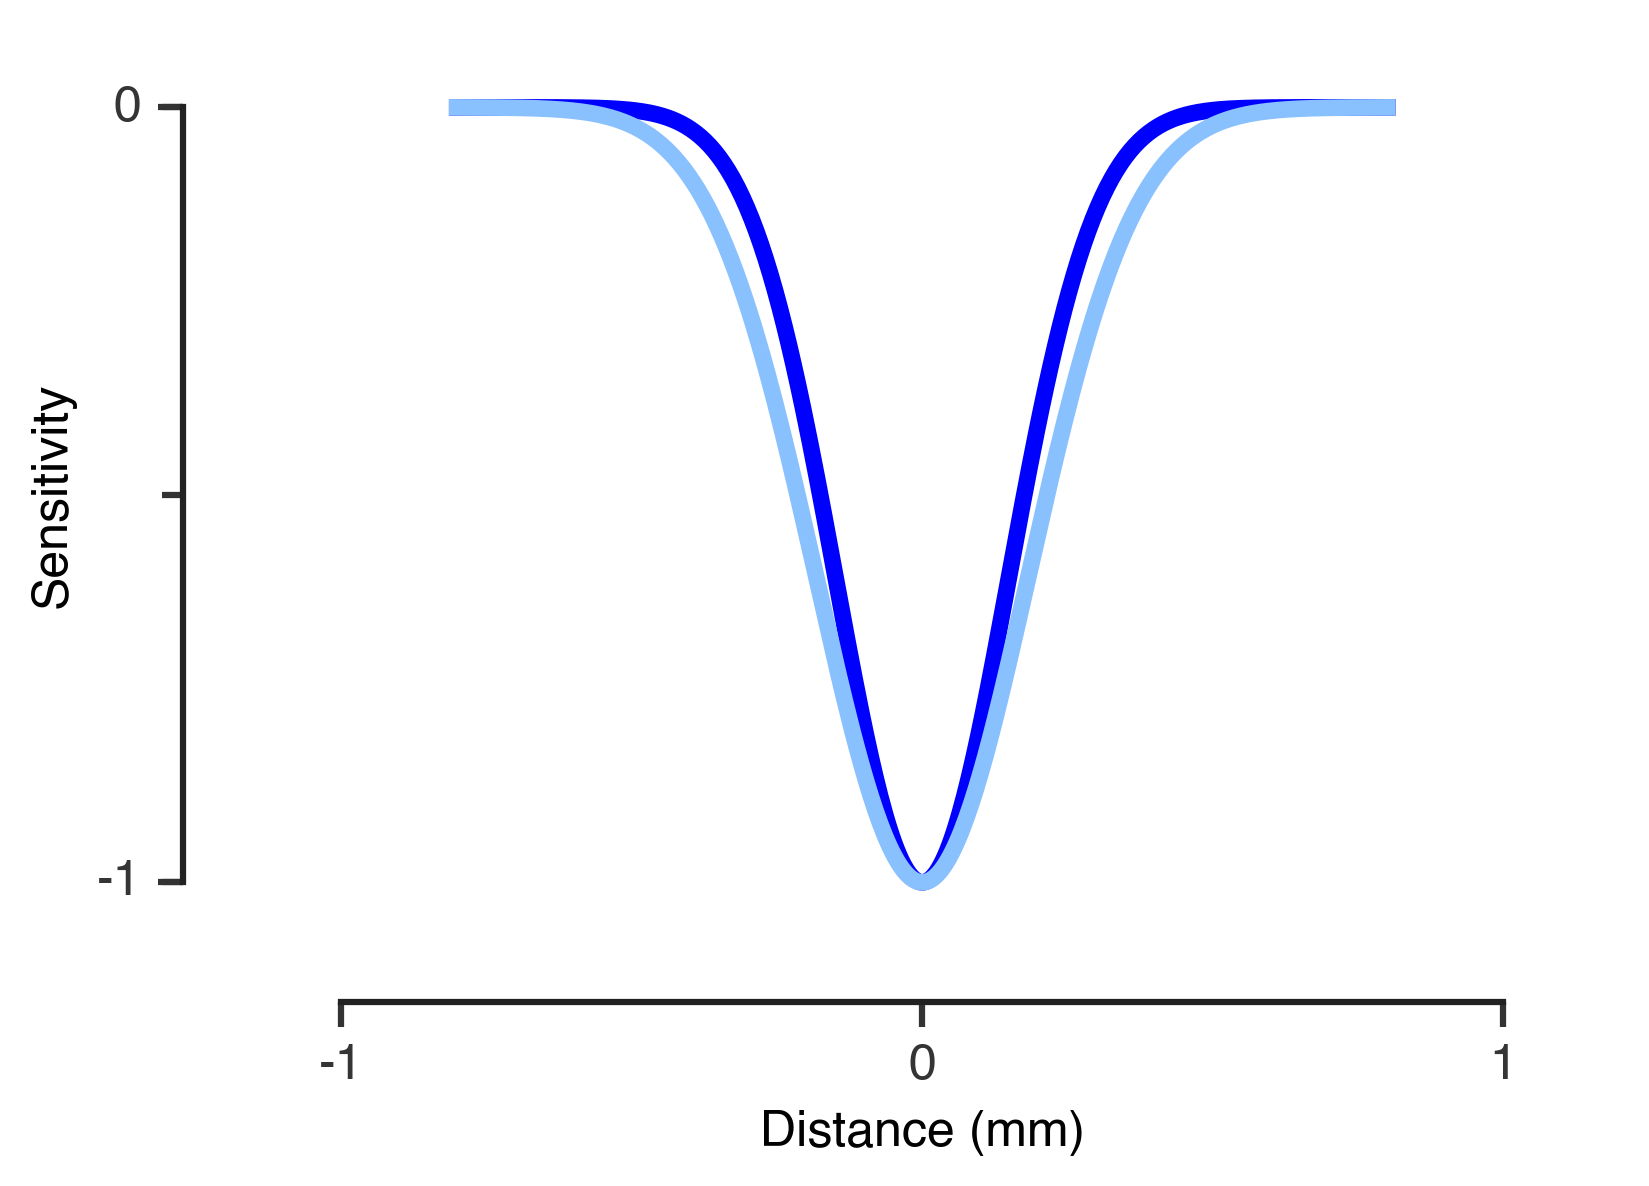

In [87]:
ganglion_surround = gaussian(space, np.mean(surround_widths['ganglion']), 0, 1)
horz_surround = gaussian(space, np.max(interneuron_fits['horizontal']), 0, 1)
ama_surround = gaussian(space, np.median(interneuron_fits['amacrine']), 0, 1)

plt.plot(space/50, -ganglion_surround/np.max(abs(ganglion_surround)), color='#0000FE', linewidth=4)
plt.plot(space/50, -horz_surround/np.max(abs(horz_surround)), color='#89C0FE', linewidth=4)
# plt.plot(space, ama_surround/np.max(abs(ama_surround)), color='#0000FE', linewidth=4)
plt.xlabel('Distance (mm)')
plt.ylabel('Sensitivity')

majorLocator = MultipleLocator(1.0)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)



plt.ylim(-1.1,0.1)
plt.xlim(-1.2,1.2)
adjust_spines(plt.gca())

(-0.6, 0.1)

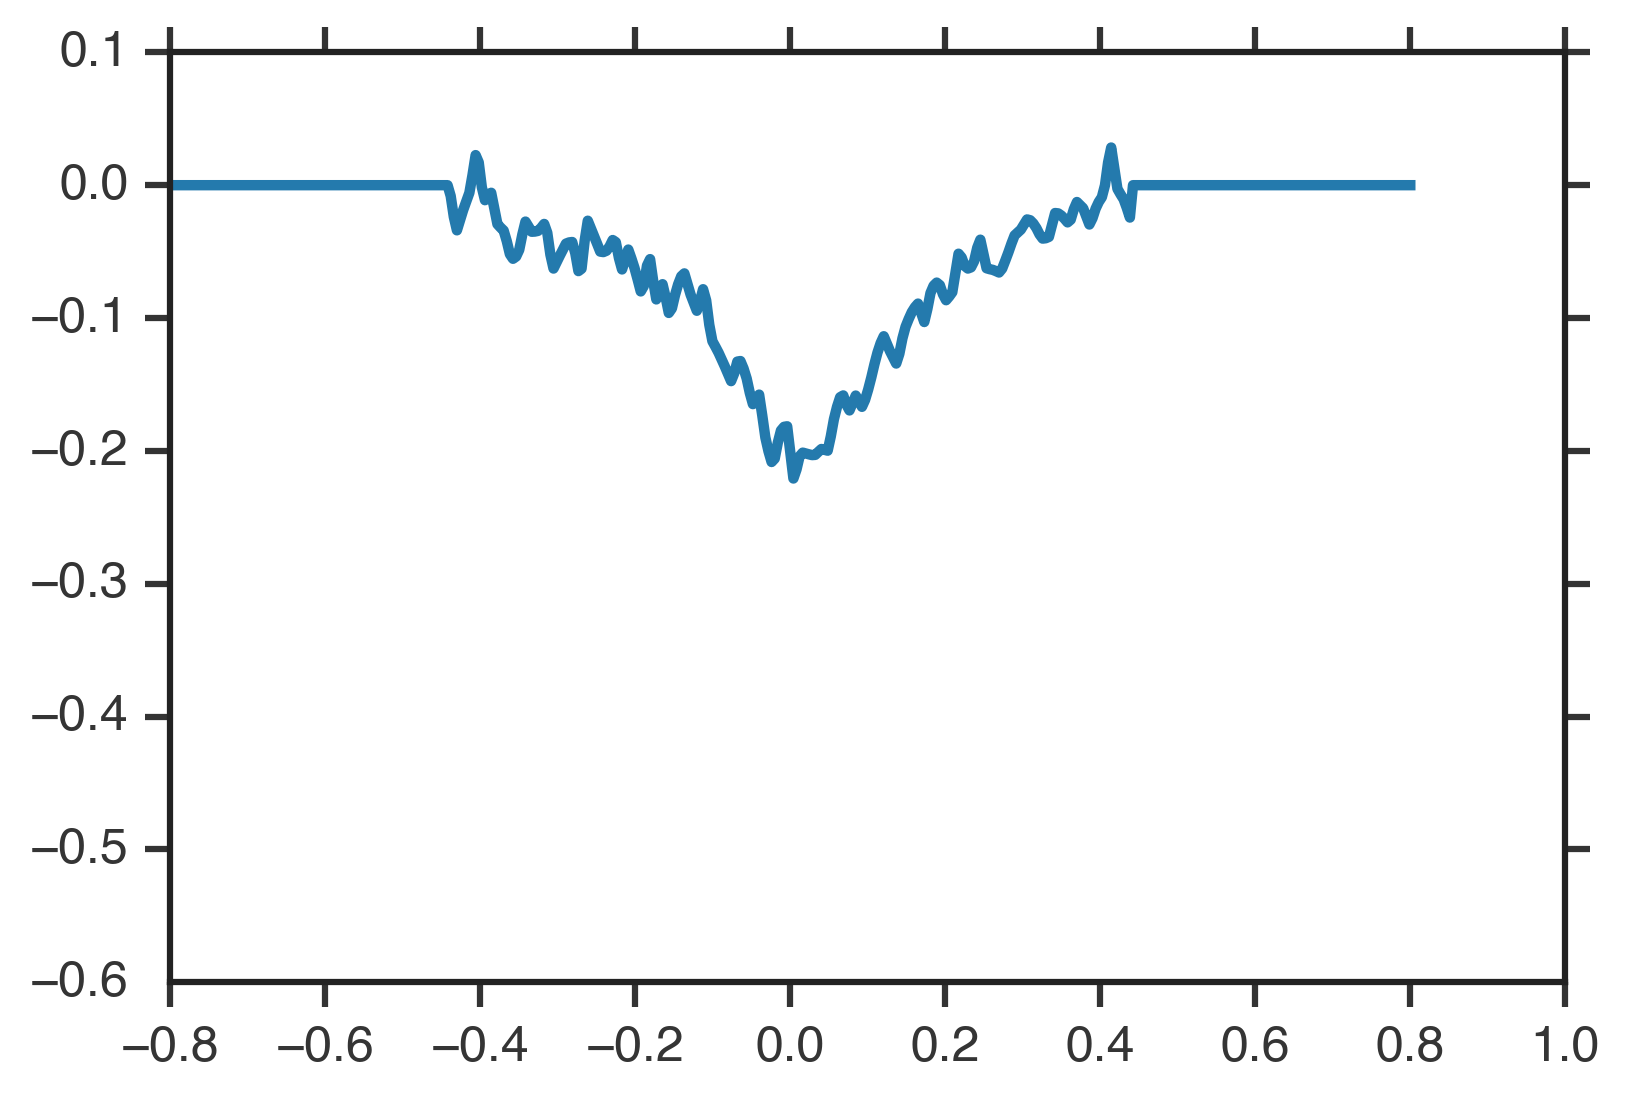

In [88]:
plt.plot(space/50, receptive_fields['horizontal'][1])
plt.ylim(-.6,.1)

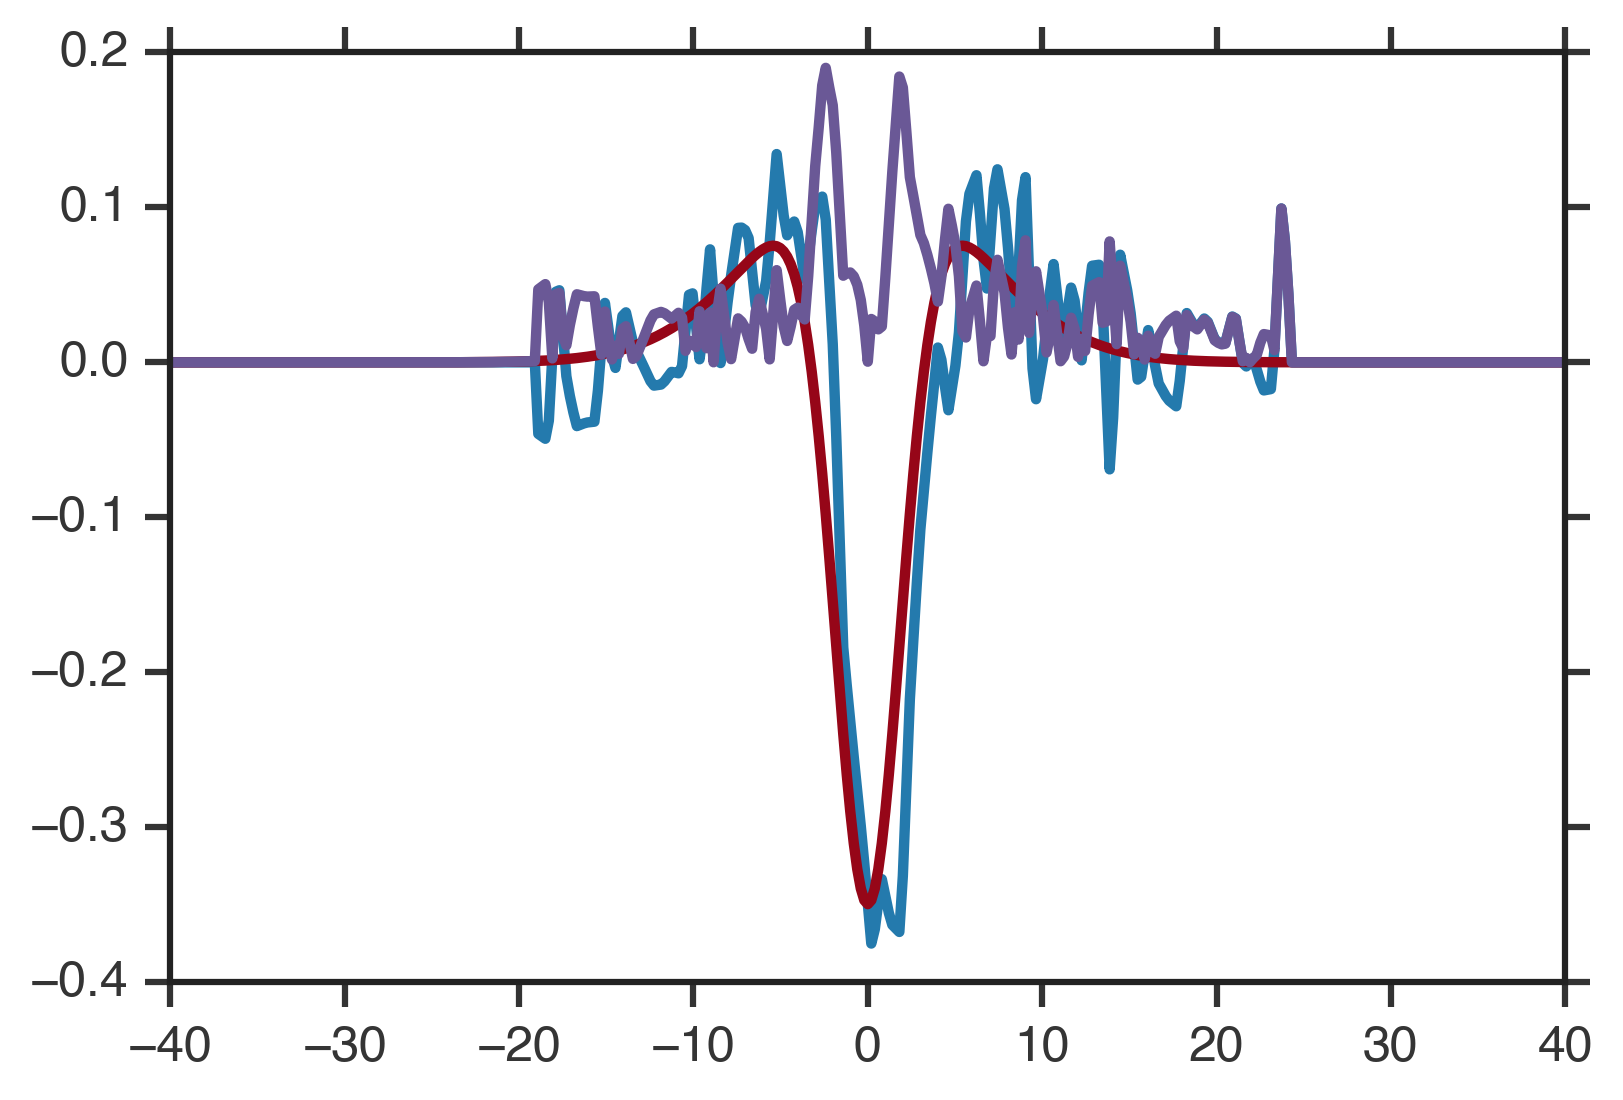

In [89]:
rf = receptive_fields['ganglion'][0]
diff_gaussian_fit = center_and_surround(space, 
                                    center_widths['ganglion'][0],
                                    surround_widths['ganglion'][0],
                                    center_strengths['ganglion'][0],
                                    surround_strengths['ganglion'][0])

plt.plot(space, rf)
plt.plot(space, diff_gaussian_fit)
plt.plot(space, abs(rf-diff_gaussian_fit))

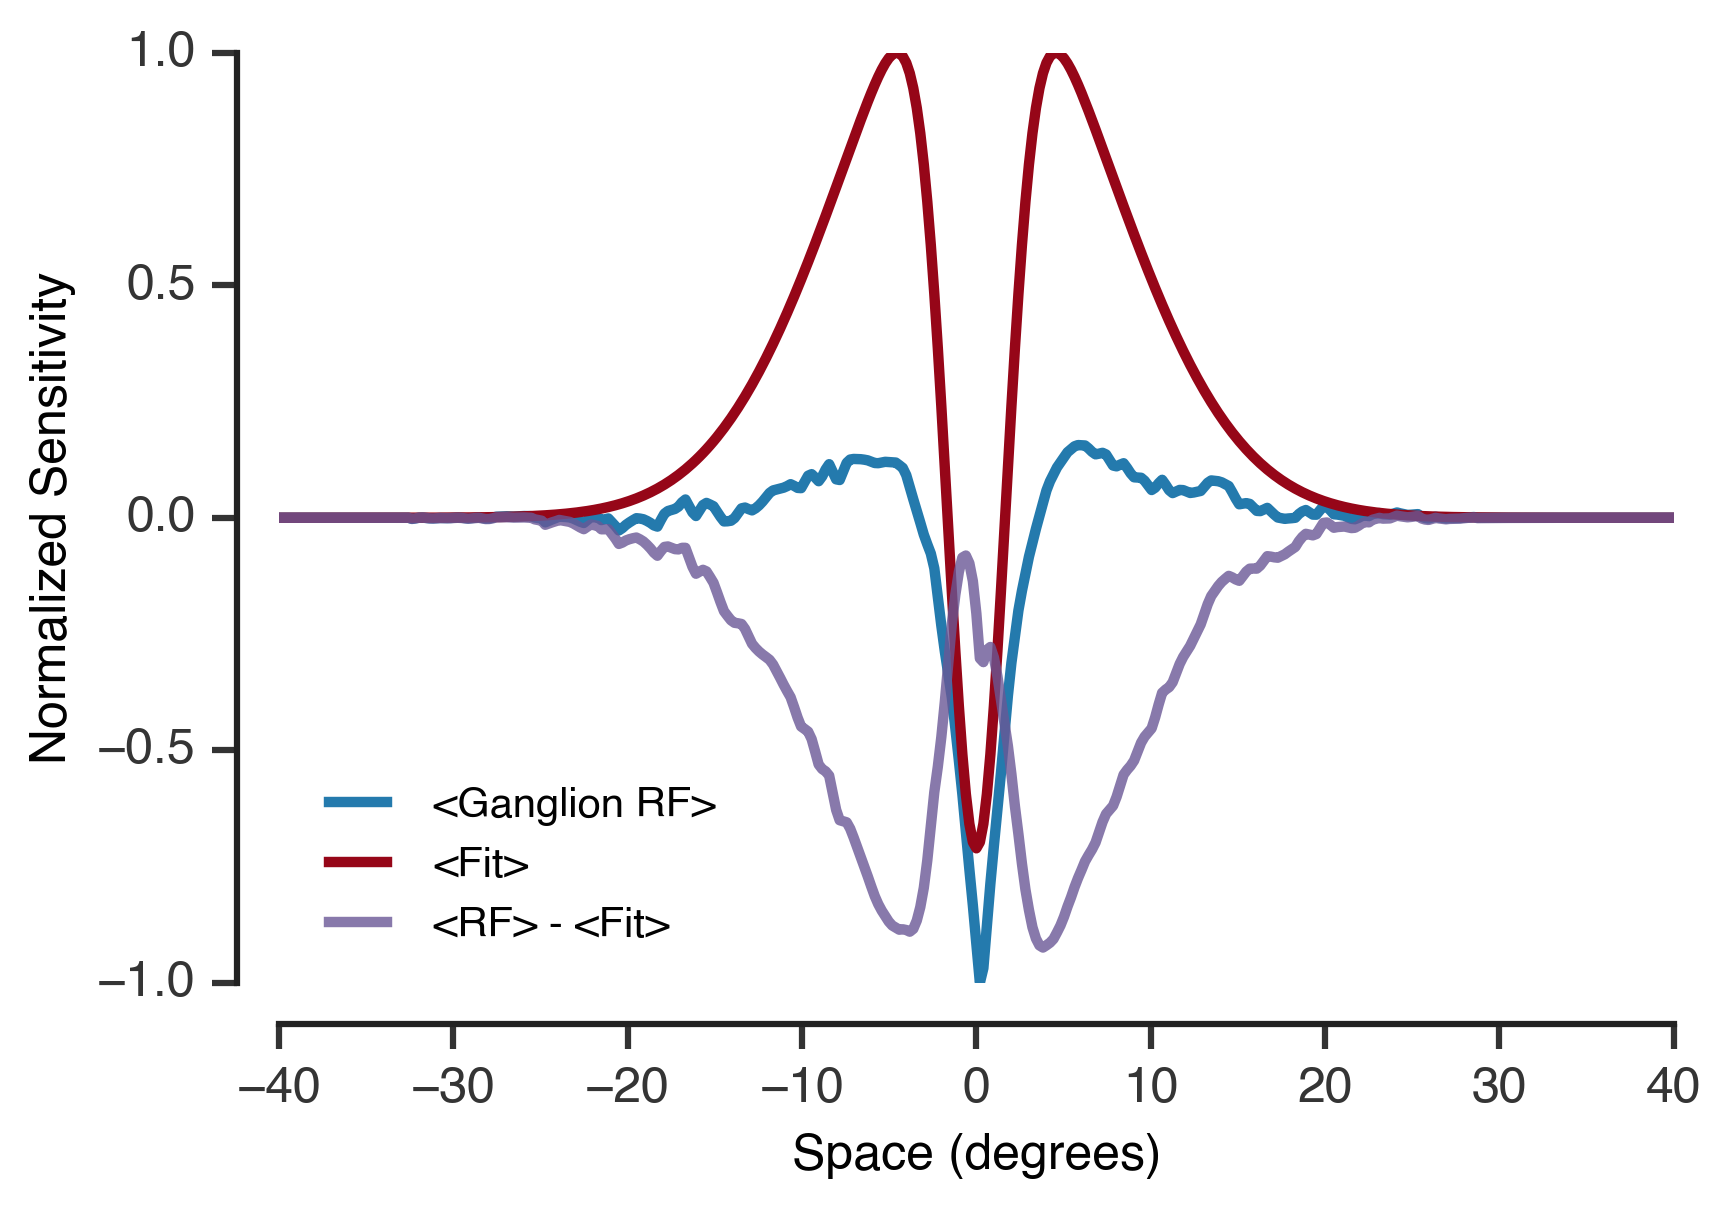

In [119]:
average_diff_gaussians = center_and_surround(space, np.mean(center_widths['ganglion']),
                                             np.mean(surround_widths['ganglion']),
                                             np.mean(center_strengths['ganglion']),
                                             np.mean(surround_strengths['ganglion']))
average_diff_gaussians /= np.max(abs(average_diff_gaussians))
normed_avg_ganglion_rf = average_ganglion_rf/np.max(abs(average_ganglion_rf))

plt.plot(space, normed_avg_ganglion_rf, label='<Ganglion RF>')
plt.plot(space, average_diff_gaussians, label='<Fit>')
plt.plot(space, normed_avg_ganglion_rf - average_diff_gaussians, alpha=0.8, label='<RF> - <Fit>')
plt.legend(frameon=False, loc='lower left', fontsize=10)
adjust_spines(plt.gca())
plt.xlabel('Space (degrees)')
plt.ylabel('Normalized Sensitivity')

In [91]:
def triple_gaussian(space, center_width, surround1_width, surround2_width,
                   center_strength, surround1_strength, surround2_strength):
    center = gaussian(x=space, sigma=center_width, mu=0, magnitude=-abs(center_strength))
    surround1 = gaussian(x=space, sigma=surround1_width, mu=0, magnitude=abs(surround1_strength))
    surround2 = gaussian(x=space, sigma=surround2_width, mu=0, magnitude=abs(surround2_strength))
    return center + surround1 + surround2

In [92]:
g = normed_avg_ganglion_rf
popt_this, pcov = curve_fit(triple_gaussian, space, g, p0=[1.5, 2.2, 7.9, -10, 20, 5])

In [93]:
popt_this

array([  1.57874997e+00,   2.69044814e+00,  -8.21768378e+00,
        -1.56897475e+01,   1.54445338e-07,   6.64082628e+01])

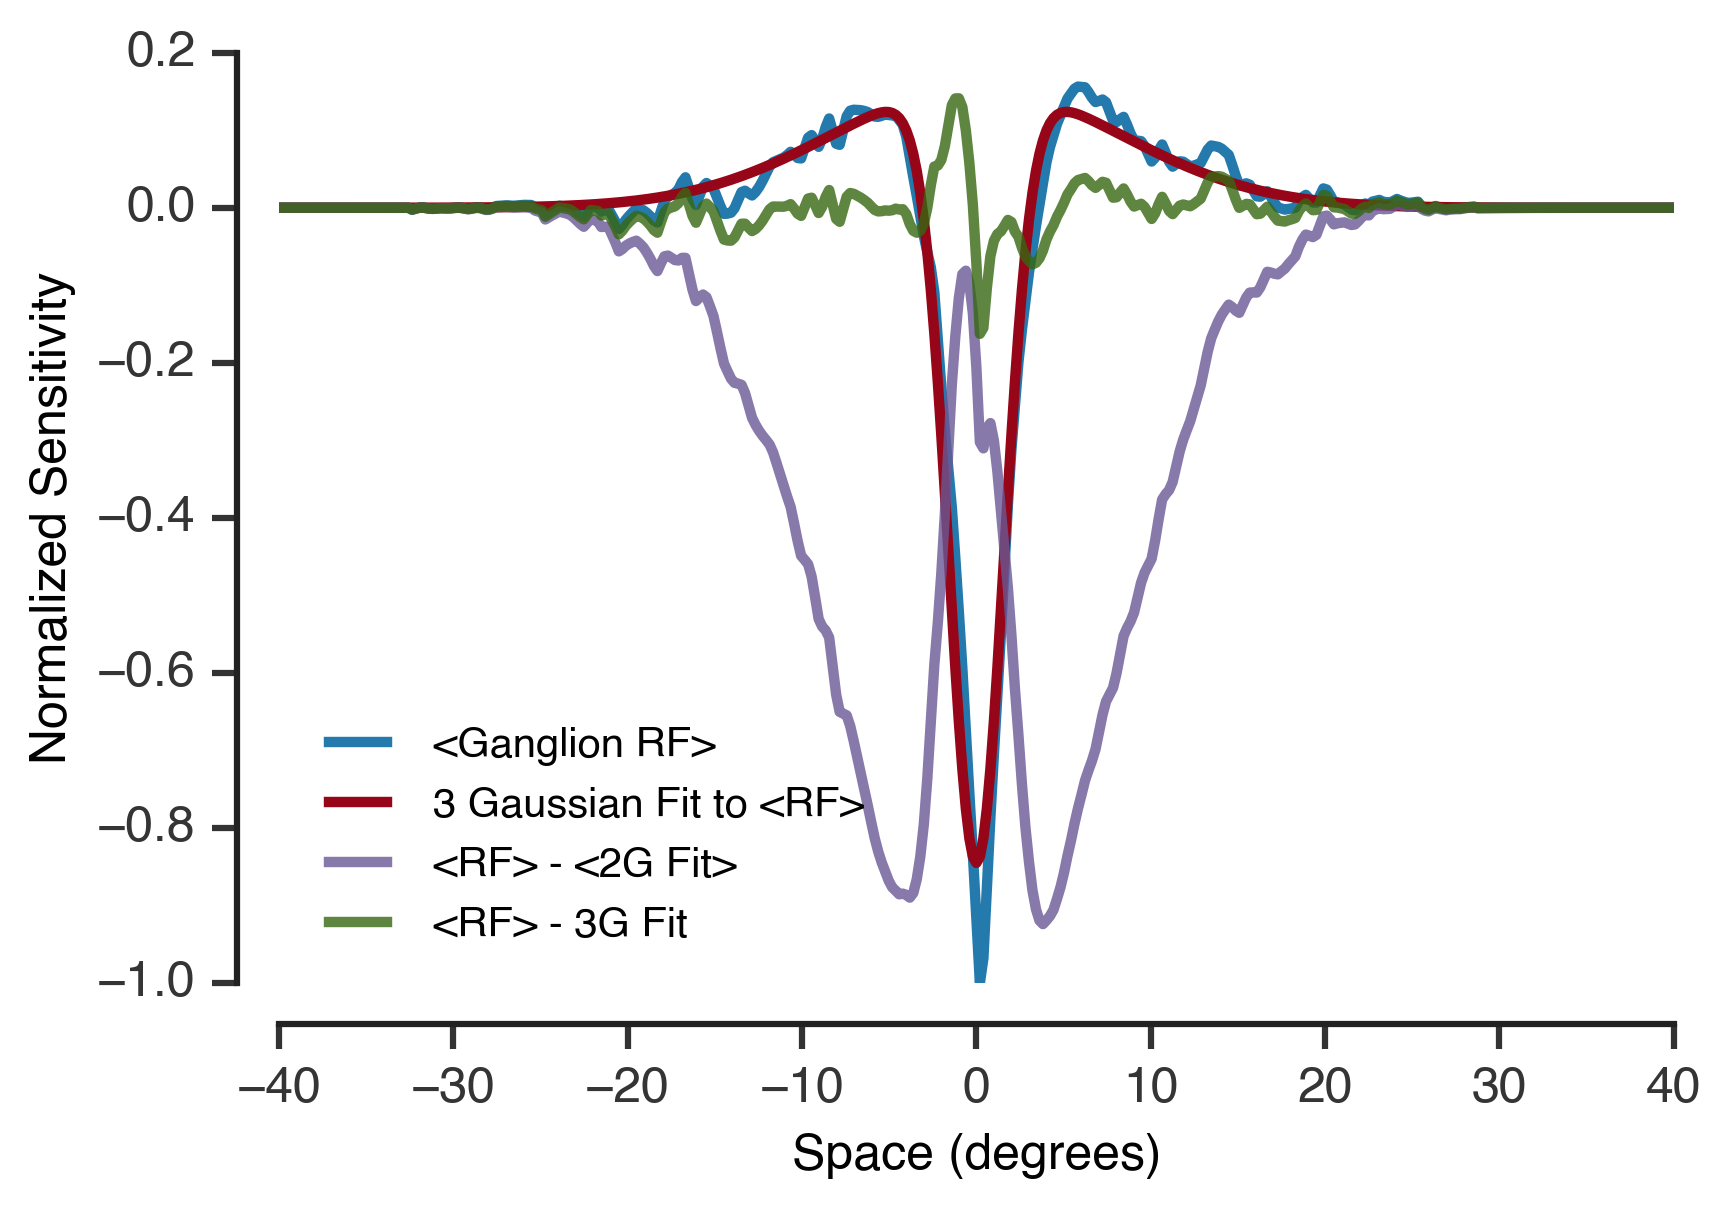

In [94]:
plt.plot(space, normed_avg_ganglion_rf, label='<Ganglion RF>')
plt.plot(space, triple_gaussian(space, *popt_this), label='3 Gaussian Fit to <RF>')
plt.plot(space, normed_avg_ganglion_rf - average_diff_gaussians, alpha=0.8, label='<RF> - <2G Fit>')
plt.plot(space, normed_avg_ganglion_rf - triple_gaussian(space, *popt_this), alpha=0.8, label='<RF> - 3G Fit')
plt.legend(frameon=False, loc='lower left', fontsize=10)
adjust_spines(plt.gca())
plt.xlabel('Space (degrees)')
plt.ylabel('Normalized Sensitivity')

In [95]:
popt_this

array([  1.57874997e+00,   2.69044814e+00,  -8.21768378e+00,
        -1.56897475e+01,   1.54445338e-07,   6.64082628e+01])

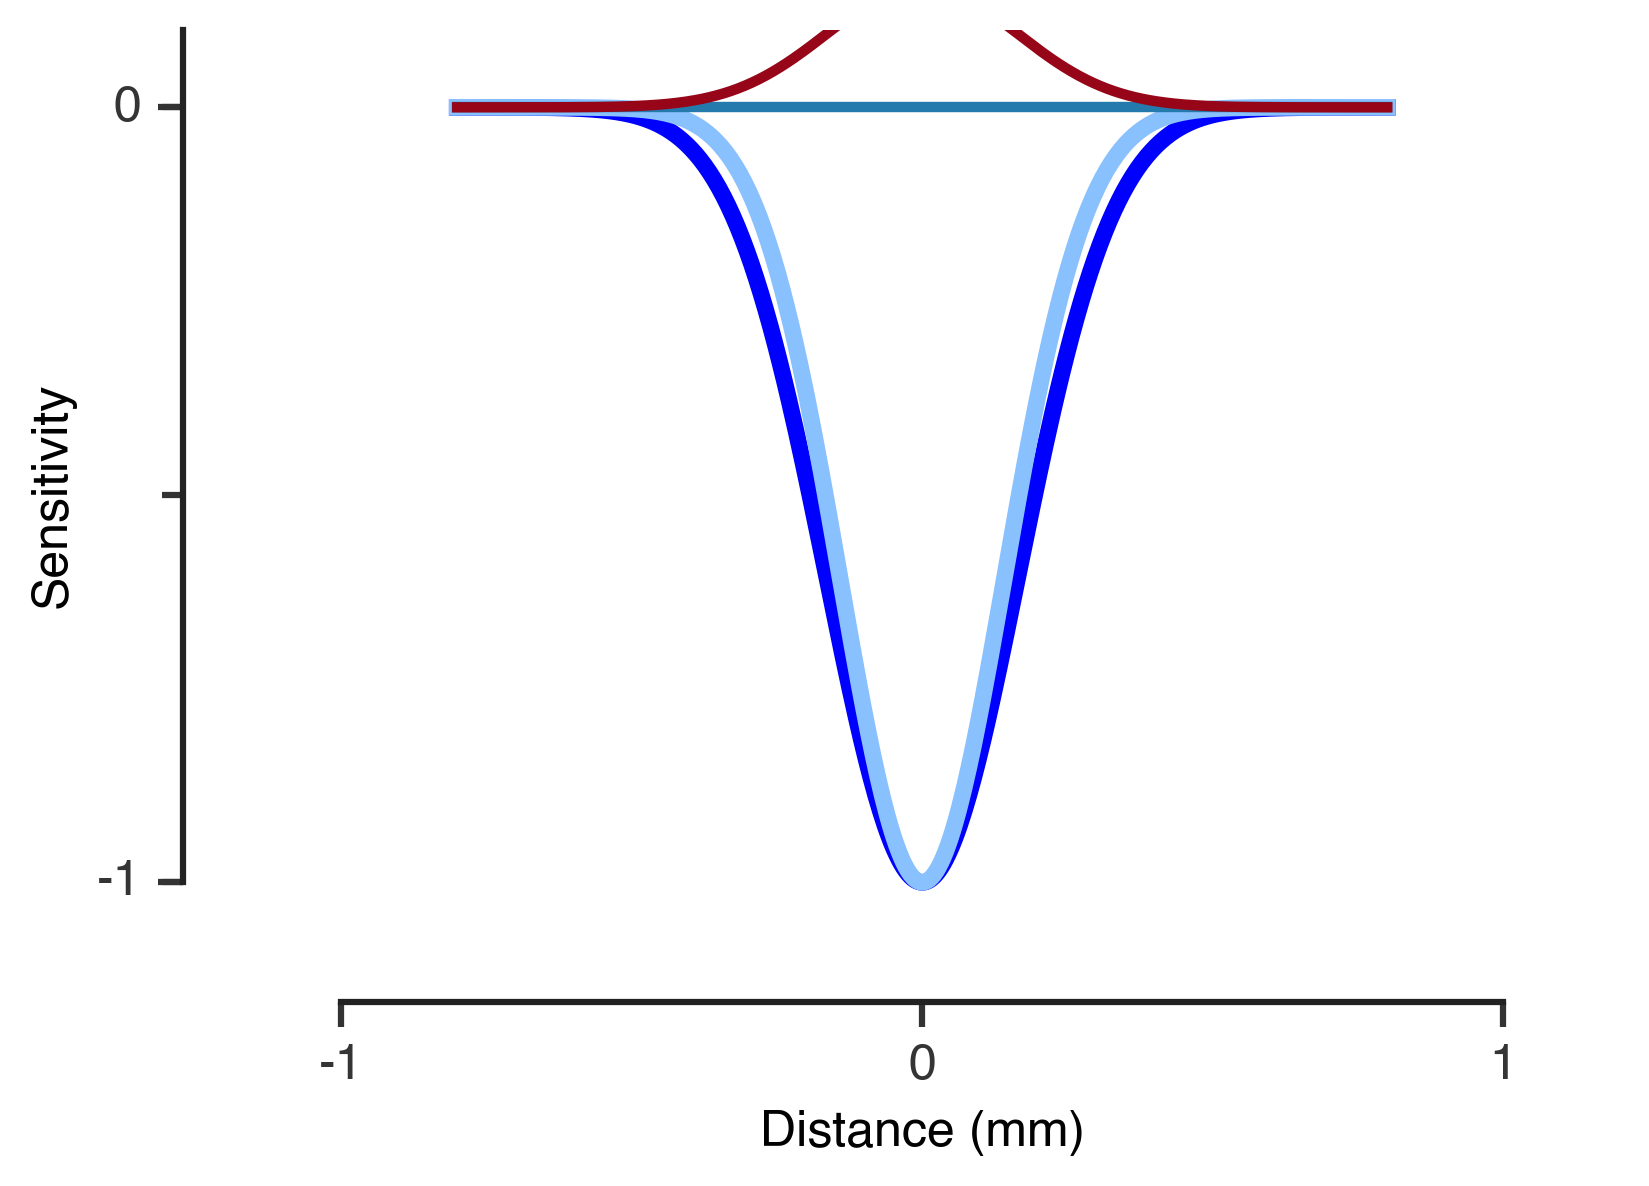

In [96]:
two_surrounds = gaussian(space, abs(popt_this[1]), 0, abs(popt_this[4])) \
                    + gaussian(space, abs(popt_this[2]), 0, abs(popt_this[-1]))
gauss1 = gaussian(space, abs(popt_this[1]), 0, abs(popt_this[4]))
gauss2 = gaussian(space, abs(popt_this[2]), 0, abs(popt_this[-1]))
horz_surround = gaussian(space, np.mean(interneuron_fits['horizontal']), 0, 1)
ama_surround = gaussian(space, np.mean(interneuron_fits['amacrine']), 0, 1)

plt.plot(space/50, -two_surrounds/np.max(abs(two_surrounds)), color='#0000FE', linewidth=4)
plt.plot(space/50, -horz_surround/np.max(abs(horz_surround)), color='#89C0FE', linewidth=4)
plt.plot(space/50, gauss1)
plt.plot(space/50, gauss2)
plt.xlabel('Distance (mm)')
plt.ylabel('Sensitivity')

majorLocator = MultipleLocator(1.0)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)



plt.ylim(-1.1,0.1)
plt.xlim(-1.2,1.2)
adjust_spines(plt.gca())

In [97]:
np.mean(interneuron_fits['horizontal'])

7.0783389185338139

In [98]:
np.mean(interneuron_fits['amacrine'])

3.1274951378246518

In [99]:
np.mean(center_widths['ganglion'])

1.7012509838194341

In [100]:
g = normed_avg_ganglion_rf
popt_this, pcov = curve_fit(triple_gaussian, space, g, p0=[1.6, 3.1, 7.1, -10.1, 1.1, 20.1])

In [101]:
popt_this

array([  1.57853627,   8.20971329,   8.21000873, -15.67989025,
         0.85070421,  65.45038185])

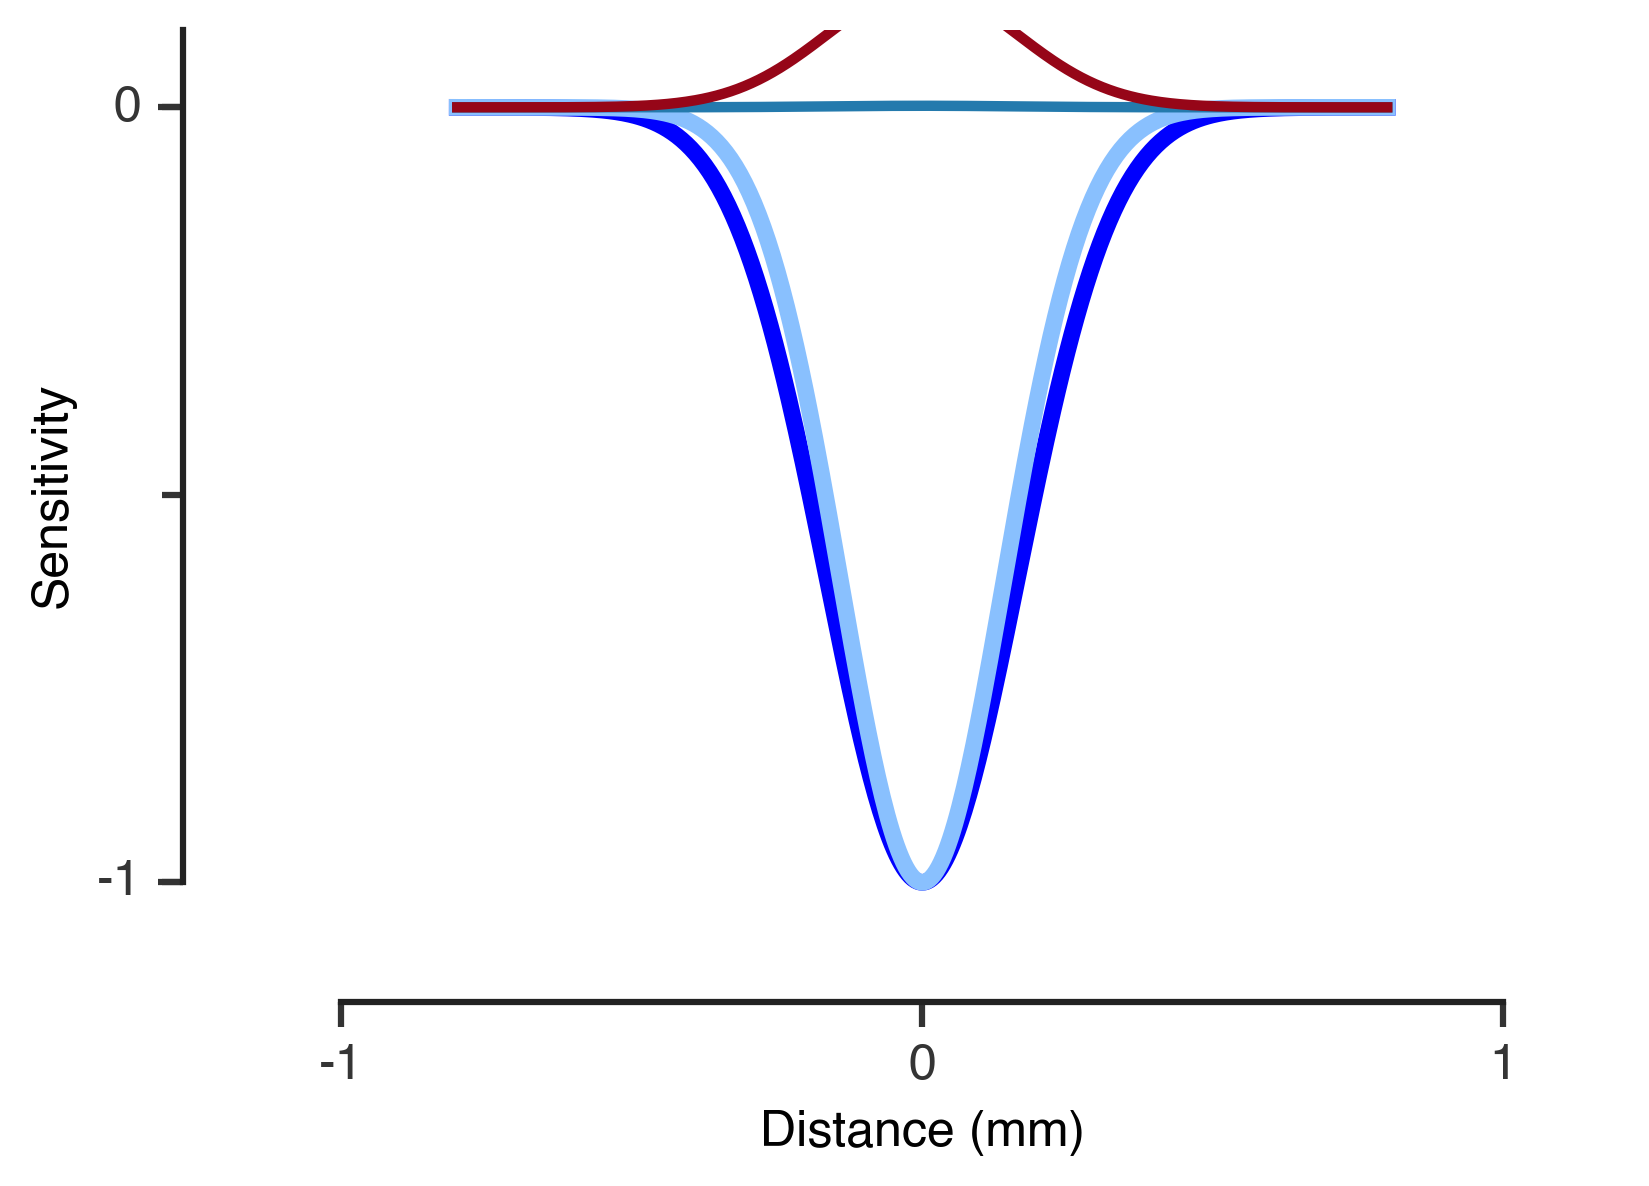

In [102]:
two_surrounds = gaussian(space, abs(popt_this[1]), 0, abs(popt_this[4])) \
                    + gaussian(space, abs(popt_this[2]), 0, abs(popt_this[-1]))
gauss1 = gaussian(space, abs(popt_this[1]), 0, abs(popt_this[4]))
gauss2 = gaussian(space, abs(popt_this[2]), 0, abs(popt_this[-1]))
horz_surround = gaussian(space, np.mean(interneuron_fits['horizontal']), 0, 1)
ama_surround = gaussian(space, np.mean(interneuron_fits['amacrine']), 0, 1)

plt.plot(space/50, -two_surrounds/np.max(abs(two_surrounds)), color='#0000FE', linewidth=4)
plt.plot(space/50, -horz_surround/np.max(abs(horz_surround)), color='#89C0FE', linewidth=4)
plt.plot(space/50, gauss1)
plt.plot(space/50, gauss2)
plt.xlabel('Distance (mm)')
plt.ylabel('Sensitivity')

majorLocator = MultipleLocator(1.0)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)



plt.ylim(-1.1,0.1)
plt.xlim(-1.2,1.2)
adjust_spines(plt.gca())

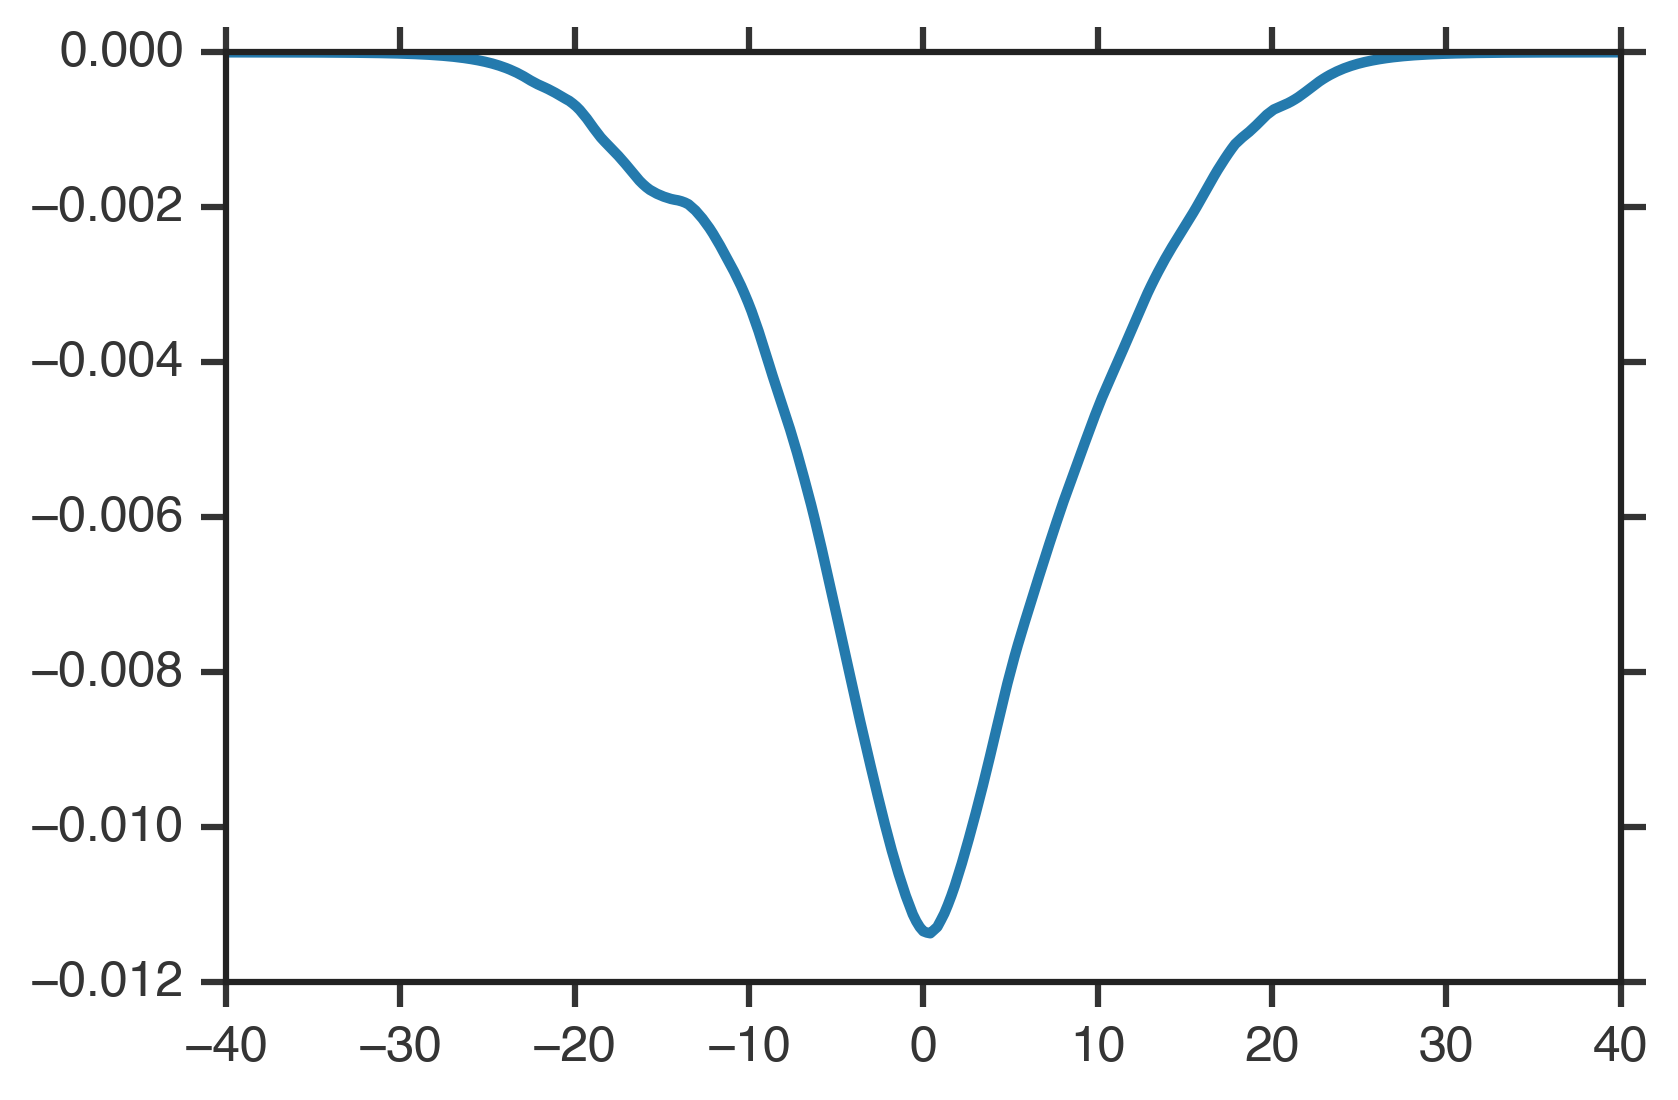

In [103]:
plt.plot(space, -horz_pf)

In [104]:
allGCs = np.loadtxt(data_path + 'allGCs.txt', skiprows=1).reshape((-1, 100, 80))
allGCs_0 = np.loadtxt(data_path + 'allGCs_0.txt', skiprows=1).reshape((-1, 100, 100))

In [105]:
allGCs.shape

(55, 100, 80)

In [106]:
allGCs_0.shape

(5, 100, 100)

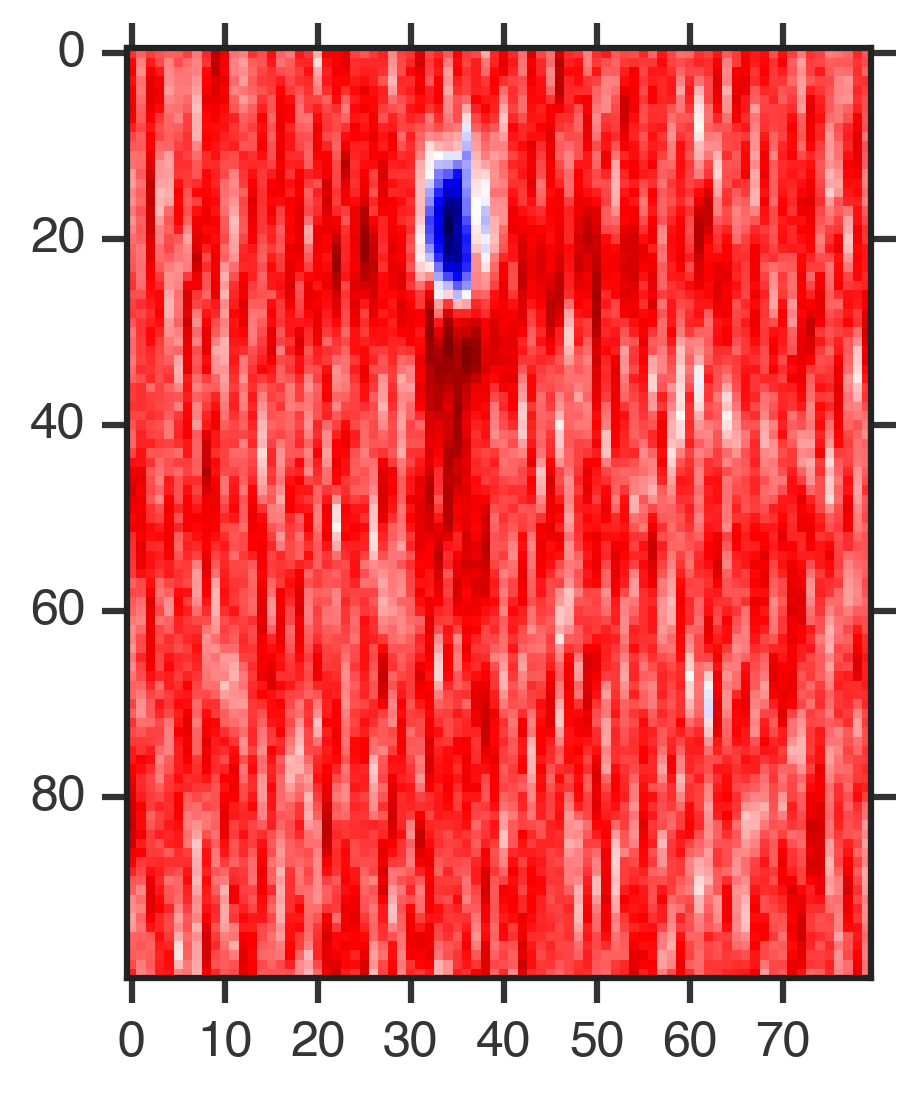

In [107]:
plt.imshow(allGCs[40,:,:], cmap='seismic')

In [108]:
import os

In [109]:
data_path_old = os.path.expanduser('~/code/surround-size/surround/data/')

In [110]:
allGCs_old = np.loadtxt(data_path_old + 'allGC.txt', delimiter="\t").reshape((100, 80, 28))

In [111]:
allGCs.shape

(55, 100, 80)

In [112]:
allGCs_old.shape

(100, 80, 28)

In [113]:
from scipy.stats import pearsonr

In [114]:
pearsonr(allGCs[0, 5], allGCs_old[5,:,0])[0]

0.48726187670077076

In [115]:
cc_matrix = np.zeros((55,28))
for new_id in range(allGCs.shape[0]):
    for old_id in range(allGCs_old.shape[-1]):
        cc_matrix[new_id, old_id] = np.mean((allGCs[new_id] - allGCs_old[:,:,old_id])**2)/np.mean([np.var(allGCs[new_id]),
                                                                                                  np.var(allGCs_old[:,:,old_id])])

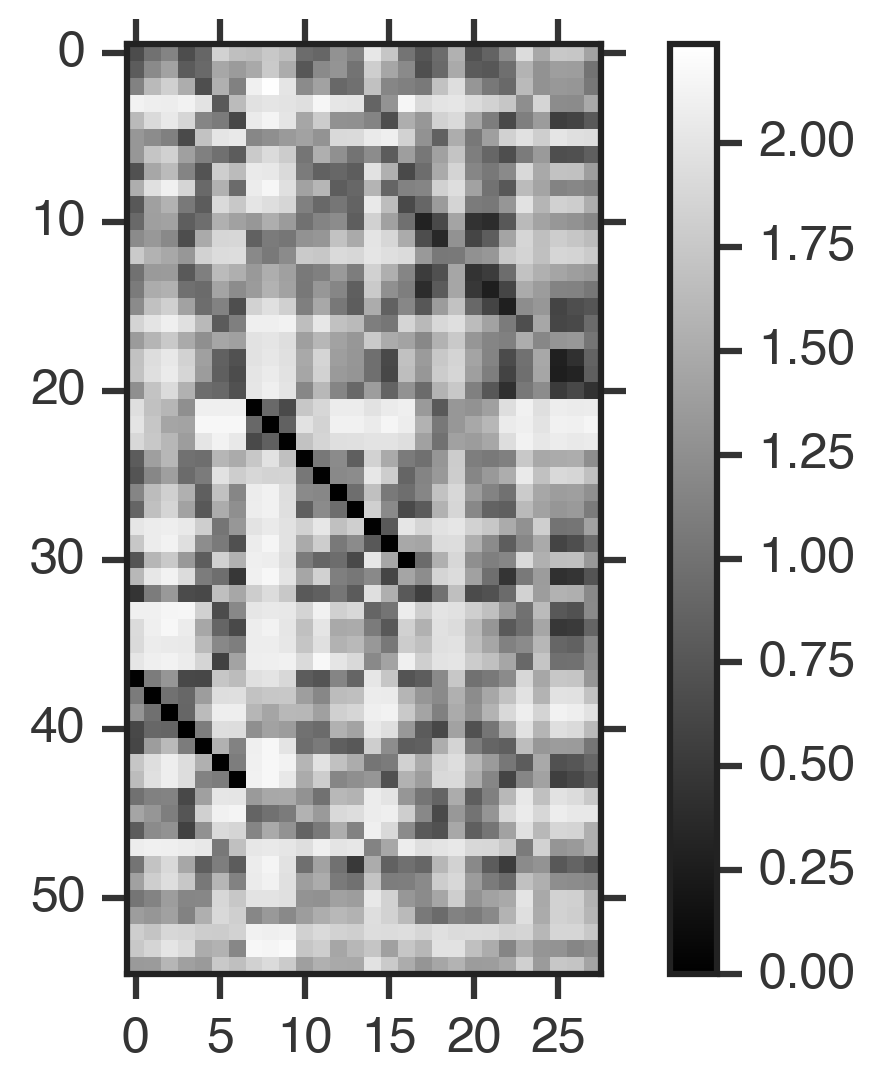

In [116]:
plt.imshow(cc_matrix)
plt.colorbar()

In [117]:
np.count_nonzero(cc_matrix)

1523

In [118]:
matching = np.prod(cc_matrix.shape) - np.count_nonzero(cc_matrix)
matching

17

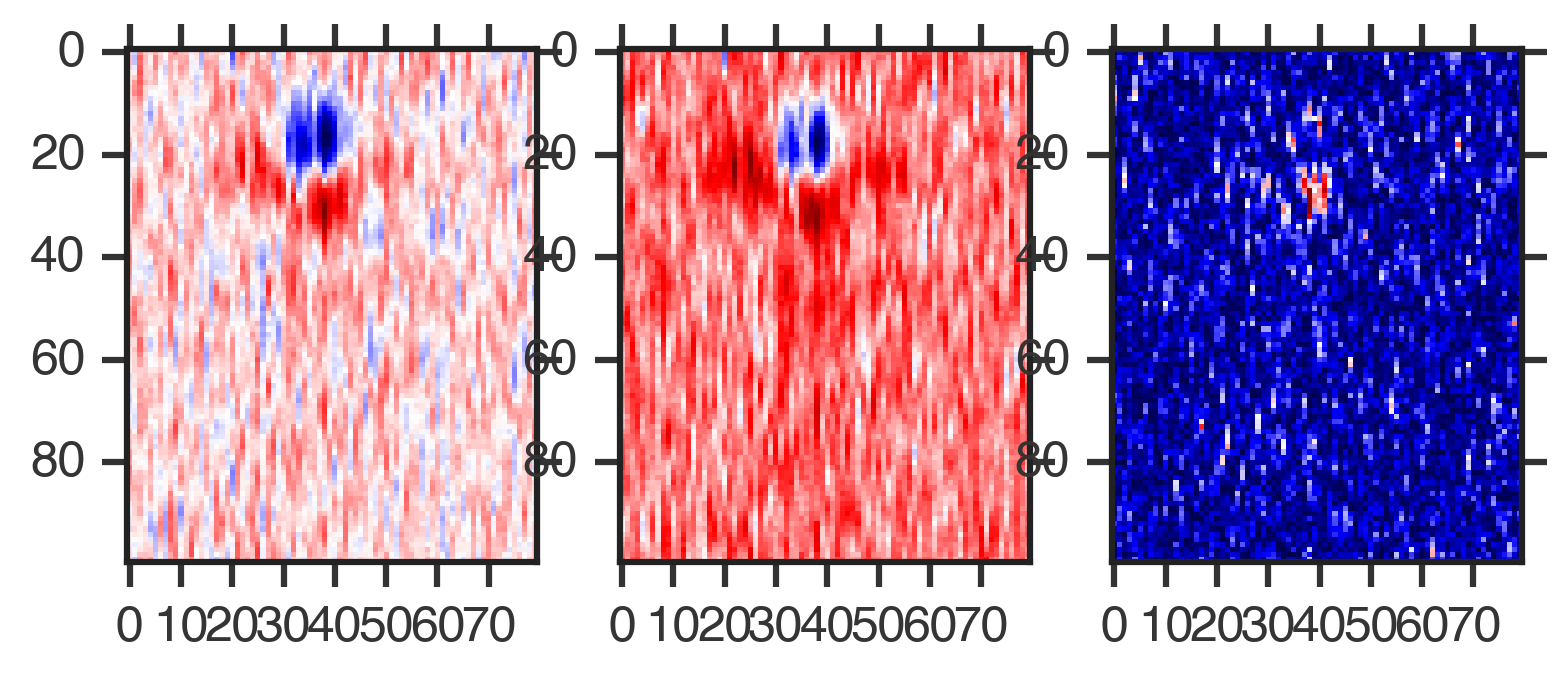

In [55]:
plt.subplot(131)
plt.imshow(allGCs[10], cmap='seismic')

plt.subplot(132)
plt.imshow(allGCs_old[:,:,17], cmap='seismic')

plt.subplot(133)
plt.imshow(abs(allGCs_old[:,:,17] - allGCs[10]), cmap='seismic')

## 17 of the 28 are definitely in this dataset, and others seem very close, but maybe with a different STA script?

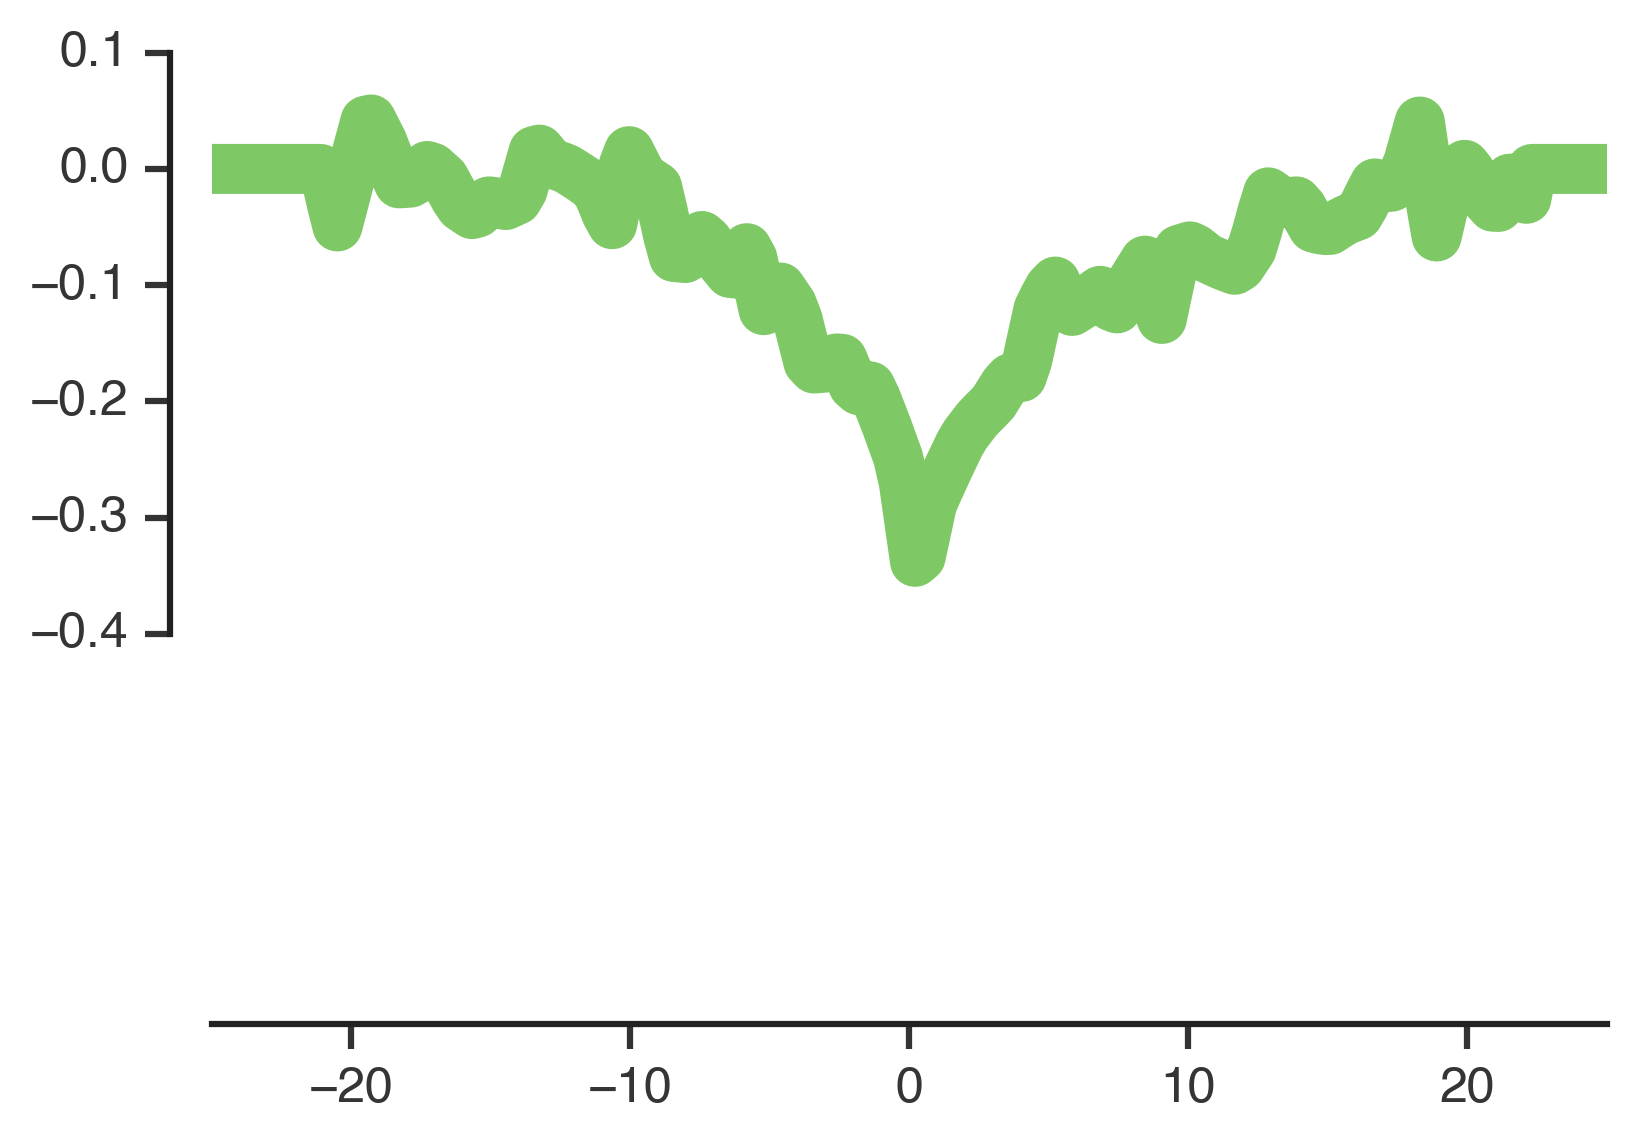

In [131]:
plt.plot(space, receptive_fields['horizontal'][0], color='#47B224', alpha=0.7, linewidth=12)
plt.ylim(-.7, 0.1)
plt.xlim(-25, 25)
adjust_spines(plt.gca())

# Fit the 60 ganglion cells to the Horz + Ama + Gauss center model

We should try both using the center from all fast off adapting/sensitizing cells, and fitting a difference of Gaussians to each cell and using that center...

In [ ]:
iterations = 100

fits = collections.defaultdict(list)
mean_squared_errors = collections.defaultdict(list)
abs_errors = collections.defaultdict(list)
variances = collections.defaultdict(list)

for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']: 
                
        popts = []
        
#         print('Fitting ganglion celltype %s.' %celltype)
        for i,rf in tqdm(enumerate(receptive_fields[celltype])):
            center = gaussian(x=space, sigma=center_widths[celltype][i], mu=0.)
            center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf

            def rf_model(horz_weight, center_weight):
                horz_weight = np.min([1.0, abs(horz_weight)])
                center_weight = np.min([1.0, abs(center_weight)])
                return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)
            
            def model_error_to_ganglion_cells(weights):
                hw, cw = weights
                modeled_rf = rf_model(hw, cw)
                normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
                return sum(abs(normed_rf - rf))

            best_fit_err = np.inf
            for itr in range(iterations):
                this_popt = minimize(model_error_to_ganglion_cells, np.random.rand(2))
                if this_popt.fun < best_fit_err:
                    best_fit_err = this_popt.fun
                    popt = this_popt
            
            # get mean squared error
            modeled_rf = rf_model(*popt.x)
            normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
            mse = np.mean((normed_rf - rf)**2)

            # truncate params between 0 and 1
#             x = np.where(popt.x < 0, 0, popt.x) # this actually is wrong, since I'm abs(params) in rf_model
#             x = np.where(x > 1, 1, x)
            x = np.where(abs(popt.x) > 1, 1, abs(popt.x))

            popts.append(x)
            abs_errors[celltype].append(popt.fun)
            mean_squared_errors[celltype].append(mse)
            variances[celltype].append(np.var(rf))

        fits[celltype] = np.stack(popts)